## Le grand debat

## Import libraries

In [0]:
!pip install git+https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git

  Cloning https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git to /private/var/folders/th/8_mg40ns12sdhl1y6xzlbyqr0000gn/T/pip-req-build-zcx2moio
  Running command git clone -q https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git /private/var/folders/th/8_mg40ns12sdhl1y6xzlbyqr0000gn/T/pip-req-build-zcx2moio
  Stored in directory: /private/var/folders/th/8_mg40ns12sdhl1y6xzlbyqr0000gn/T/pip-ephem-wheel-cache-jppac4ob/wheels/95/b7/c0/e249ca2690c04f6106b9581c5e4111287f71dbd85bac903445
Successfully built FrenchLefffLemmatizer


In [0]:
# basics
import pandas as pd
import numpy as np
import datetime
import os

# string
import string
!pip install unidecode
import unidecode
import re
from textwrap import wrap # wrapping long text into lines

# plot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from wordcloud import WordCloud
from mpl_toolkits.axes_grid1 import make_axes_locatable
# %matplotlib inline

# text mining
import nltk
from nltk.tokenize import RegexpTokenizer


# Because we have some long strings to deal with:
pd.options.display.max_colwidth = 300



replacement_patterns = [
    (r'won\'t', 'will not'),
    (r'can\'t', 'cannot'),
    (r'i\'m', 'i am'),
    (r'ain\'t', 'is not'),
    (r'(\w+)\'ll', '\g<1> will'),
    (r'(\w+)n\'t', '\g<1> not'),
    (r'(\w+)\'ve', '\g<1> have'),
    (r'(\w+)\'s', '\g<1> is'),
    (r'(\w+)\'re', '\g<1> are'),
    (r'(\w+)\'d', '\g<1> would'),
]

class RegexpReplacer(object):
    def __init__(self, patterns=replacement_patterns): 
        self.patterns = [(re.compile(regex), repl) for (regex, repl) in patterns]
    def replace(self, text):
        s = text
        for (pattern, repl) in self.patterns:
            s = re.sub(pattern, repl, s) 
        return s

replacer=RegexpReplacer()

from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()

from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer
lemmatizer = FrenchLefffLemmatizer()
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stops=set(stopwords.words('french'))

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nathanamar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nathanamar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Import dataset

In [0]:
themes = {
    'https://www.data.gouv.fr/fr/datasets/r/2434c415-5246-4c00-bac8-210cfbb4af5e':'La fiscalité et les dépenses publiques',
    'https://www.data.gouv.fr/fr/datasets/r/b687441f-bad7-451c-851c-122619f6fa6e':"Organisation de l'état et des services publics",
    'https://www.data.gouv.fr/fr/datasets/r/debe363c-6fec-460a-949f-a902b1ee30bd':'Démocratie et citoyenneté',
    'https://www.data.gouv.fr/fr/datasets/r/0df78783-ecaf-4591-8b50-c7d59868a27e':'La transition écologique'
}

filenames = list(themes.keys())
themes = list(themes.values())

We can now import each file, all in one list of dataframes for easier use.

We pay special attention to data types: ZipCode must be read as strings and date columns as timestamps.

In [0]:
filepaths = [os.path.join("", filename) for filename in filenames]
col_date = ['createdAt', 'publishedAt', 'updatedAt']
df_list = [pd.read_csv(filepath, low_memory=False,
                       dtype={'authorZipCode':'str'},
                       parse_dates=col_date) for filepath in filepaths]

## Discovering the dataset

The 4 dataframes share some common variables, other columns are questions that are specific to the theme. The common variables are the following:


In [0]:
col_common = set.intersection(*[set(df.columns) for df in df_list])
col_common

{'authorId',
 'authorType',
 'authorZipCode',
 'createdAt',
 'id',
 'publishedAt',
 'reference',
 'title',
 'trashed',
 'trashedStatus',
 'updatedAt'}

Let's have a look at the missing values


In [0]:
pd.concat([df[df.columns.intersection(col_common)] for df in df_list]).isnull().mean() * 100


id                0.000000
reference         0.000000
title             0.000299
createdAt         0.000000
publishedAt       0.000898
updatedAt        94.240473
trashed           0.000000
trashedStatus    99.983540
authorId          0.000000
authorType       16.435527
authorZipCode     0.000000
dtype: float64

Each line of the dataframes corresponds to one contribution: the answers of an author to the questions of the corresponding theme. Let's see how many contributions we have for each dataset, and how many questions:


In [0]:
df_infos = pd.DataFrame({
     'theme': themes,
     'nb_contributions': [df.shape[0] for df in df_list],
     'nb_questions': [sum(~df.columns.isin(col_common)) for df in df_list]
    })
df_infos

theme  nb_contributions  \
0          La fiscalité et les dépenses publiques            113521   
1  Organisation de l'état et des services publics             67301   
2                       Démocratie et citoyenneté             65758   
3                        La transition écologique             87562   

   nb_questions  
0             8  
1            33  
2            37  
3            16

##### We can ask ourself when were the contributions submitted?

We will have a look at the createdAt variable to spot when the contributions were submitted, and at what time of the day.


## Daily contributions


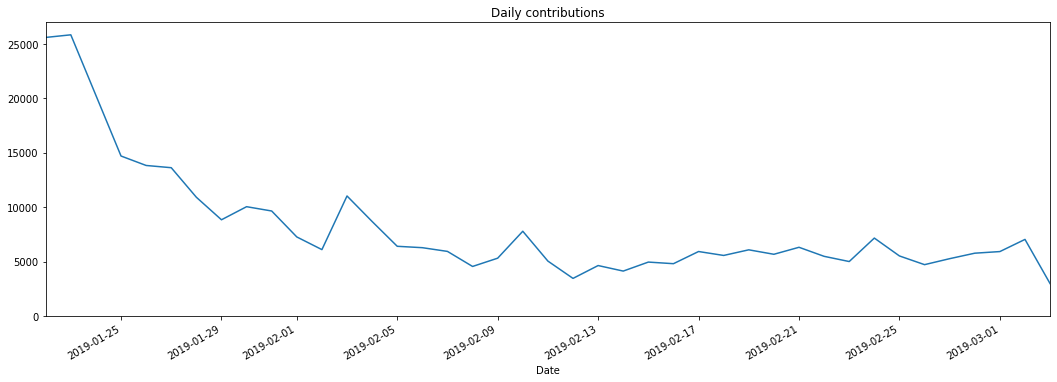

In [0]:
day_contrib = pd.concat([df.createdAt for df in df_list]).dt.date.value_counts().sort_index()

fig, ax = plt.subplots(figsize = (18,6))
day_contrib.plot()
ax.set_title('Daily contributions')
ax.set_xlabel('Date')
fig.autofmt_xdate()
ax.set_ylim(bottom=0)
plt.show(fig)

We can see a first peak at the very beginning of the Grand Débat.

Let's look also at the time the contributions were made:

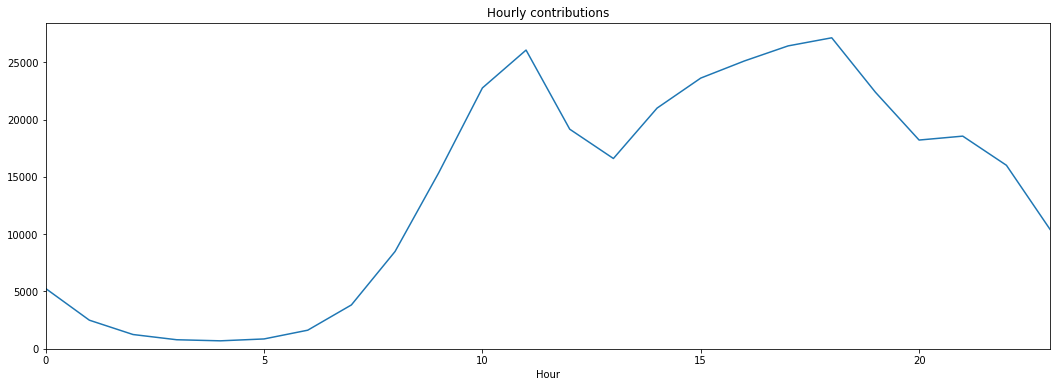

In [0]:
hour_contrib = pd.concat([df.createdAt for df in df_list]).dt.hour.value_counts().sort_index()

fig, ax = plt.subplots(figsize = (18,6))
hour_contrib.plot()
ax.set_title('Hourly contributions')
ax.set_xlabel('Hour')
ax.set_ylim(bottom=0)
plt.show(fig)

The number of contribution per hour reaches a peak in the late afternoon, between 18h and 19h

### Who are the contributors?

In this section we will have a closer look at the authors of the Grand Débat. For each contribution we have an authorID that is shared among datasets.


In [0]:
pd.DataFrame({'theme':themes,
              'max_contrib_per_author':[df.groupby('authorId').size().max() for df in df_list]})

theme  max_contrib_per_author
0          La fiscalité et les dépenses publiques                     104
1  Organisation de l'état et des services publics                      54
2                       Démocratie et citoyenneté                      57
3                        La transition écologique                      79

Since we focus on contributors, we aggregate the table by authorId in order to have one line per author. If an author has several authorType or authorZipCode, we keep the most frequent one: the mode.

We also add a count statistics: how many contributions that author made over the whole dataset.

In [0]:
def mode_na(x): 
    m = pd.Series.mode(x)
    return m.values[0] if not m.empty else np.nan

authors = pd.concat([df[df.columns.intersection(col_common)] for df in df_list])
# With pandas>=0.24, we would use: pandas.Series.mode
authors = authors.groupby('authorId').agg({'id':'count', # number of contributions
                                           'authorType':mode_na,
                                           'authorZipCode':mode_na})

The first statistics we can get out of this new dataframe is the number of distinct contributors

In [0]:
authors.shape[0]


159372

There are more than 150,000 distinct contributors.

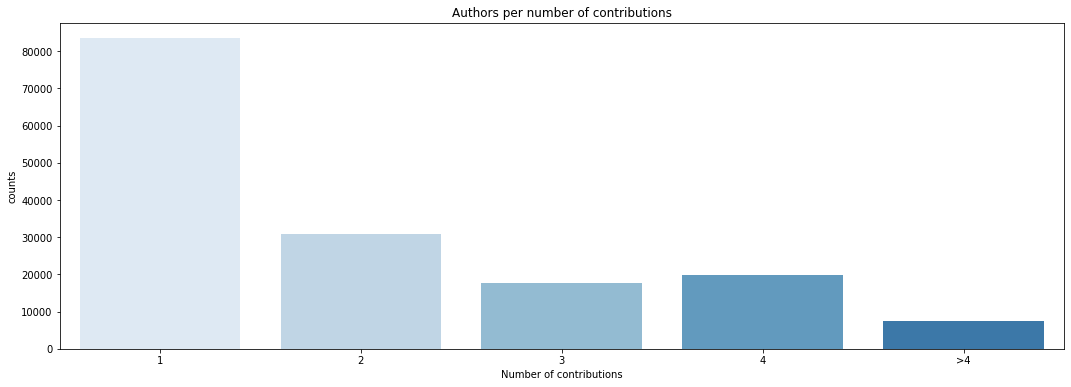

In [0]:
n_contrib = authors.id.value_counts().reset_index(name='counts')
n_contrib.loc[n_contrib['index'] > 4, 'index'] = '>4'
n_contrib = n_contrib.groupby('index').agg(sum)
fig, ax = plt.subplots(figsize=(18,6))
ax = sns.barplot(x='index',
            y='counts',
            data=n_contrib.reset_index(),
            palette=sns.color_palette('Blues'))
ax.set_xlabel('Number of contributions')
ax.set_title('Authors per number of contributions')
plt.show()

As can be seen, around 50% of the authors submitted a single contribution.

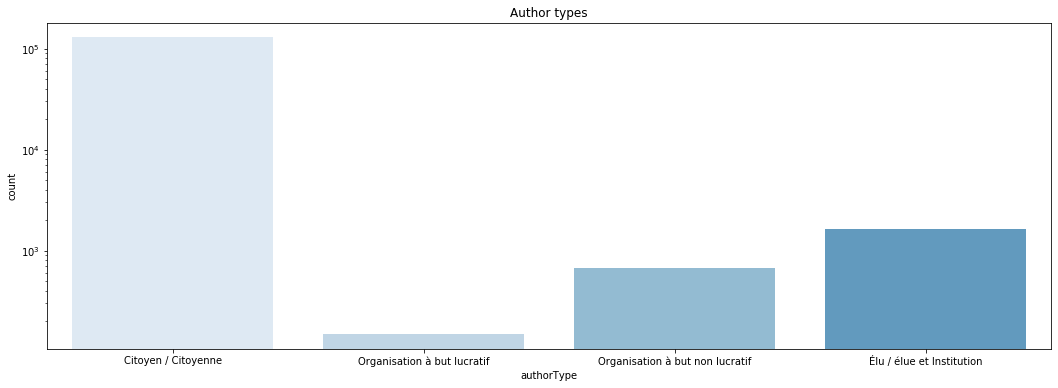

In [0]:
fig, ax = plt.subplots(figsize=(18,6))
ax = sns.countplot(x='authorType',
                   data=authors,
                   palette=sns.color_palette('Blues'))
ax.set_yscale('log')
ax.set_title('Author types')
plt.show()


We notice that the great majority of respondents, are citizens  i.e. they are neither politicals, officials nor part of an organisation.

After this very brief dataset analysis, it is time to focus on the variables of interest: the questions. Each dataframe contains several questions, but we will try to treat them all at once.

The column names for the questions are a bit messy, we will rename them for more clarity. We build a dataframe containing information about each question: old and new name, title, and the theme and dataframe they are linked to.


In [0]:
questions = pd.concat([pd.DataFrame({'old_name':df_list[i].columns,
                                     'df_id':i,
                                     'theme':themes[i]}) for i in range(len(df_list))])
questions = questions[-questions["old_name"].isin(col_common)].reset_index(drop=True)
questions = questions.assign(new_name=(pd.Series(
    ['Q{}'.format(i) for i in range(1, questions.shape[0] + 1)])))
questions = questions.assign(question=pd.Series(
    [name.split(' - ')[1] for name in questions.old_name]))

In [0]:
# Questions rename
dict_rename = {old:new for old, new in zip(questions.old_name,questions.new_name)}
for df in df_list:
    df.rename(columns=dict_rename,inplace=True)
    
questions.head()


old_name  \
0  QUXVlc3Rpb246MTYy - Quelles sont toutes les choses qui pourraient être faites pour améliorer l'information des citoyens sur l'utilisation des impôts ?   
1                                                        QUXVlc3Rpb246MTYz - Que faudrait-il faire pour rendre la fiscalité plus juste et plus efficace ?   
2                                                                   QUXVlc3Rpb246MTY0 - Quels sont selon vous les impôts qu'il faut baisser en priorité ?   
3                                                                       QUXVlc3Rpb246MjA2 - Afin de financer les dépenses sociales, faut-il selon vous...   
4          QUXVlc3Rpb246MjA1 - S'il faut selon vous revoir les conditions d'attribution de certaines aides sociales, lesquelles doivent être concernées ?   

   df_id                                   theme new_name  \
0      0  La fiscalité et les dépenses publiques       Q1   
1      0  La fiscalité et les dépenses publiques       Q2   
2      0  La fiscalité et les dépenses publiques       Q3   
3      0  La fiscalité et les dépenses publiques       Q4   
4      0  La fiscalité et les dépenses publiques       Q5   

                                                                                                                             question  
0  Quelles sont toutes les choses qui pourraient être faites pour améliorer l'information des citoyens sur l'utilisation des impôts ?  
1                                                        Que faudrait-il faire pour rendre la fiscalité plus juste et plus efficace ?  
2                                                                   Quels sont selon vous les impôts qu'il faut baisser en priorité ?  
3                                                                       Afin de financer les dépenses sociales, faut-il selon vous...  
4          S'il faut selon vous revoir les conditions d'attribution de certaines aides sociales, lesquelles doivent être concernées ?

In [0]:
questions.shape


(94, 5)

We can see that the dataset concatened contains 94 questions.

We created for ourself a csv to a better understanding of all the questions.

In [0]:
fichier_csv = questions.to_csv(r"questions.csv",index=False)


For each question, we compute the following statistics:

- nbrow: number of rows (i.e. number of contributions for the corresponding theme)
- nbnnull: number of answers that are not null (answer is null if the contributor skipped that question)
- nbunique: number of distinct answers
- nnull_rate: nbnnull/nbrow * 100
- unique_rate: nbunique/nbnnull * 100

In [0]:
questions['nbrow'] = questions.apply(lambda g: df_list[g.df_id].shape[0], axis=1)
questions['nbnnull'] = questions.apply(lambda g: df_list[g.df_id].loc[:,g.new_name]\
                                       .notnull().sum(), axis=1)
questions['nbunique'] = questions.apply(lambda g: df_list[g.df_id].loc[:,g.new_name]\
                                        .nunique(), axis=1)

questions['nnull_rate'] = questions.nbnnull/questions.nbrow * 100
questions['unique_rate'] = questions.nbunique/questions.nbnnull * 100

We can notice that some questions have very few distinct answers:

In [0]:
questions['closed'] = questions['nbunique'] <= 3
sum(questions.closed)

19

Those 19 questions are closed-ended question: the answer is forced into a few choices, mainly Yes or No.

We can now aggregate at the theme scale:

In [0]:
questions.groupby(['theme']).agg({'question':'count', 'closed':'sum',
                                  'nbrow':'mean', 'nnull_rate':'mean'})

question  closed   nbrow  \
theme                                                                      
Démocratie et citoyenneté                             37     7.0   65758   
La fiscalité et les dépenses publiques                 8     0.0  113521   
La transition écologique                              16     4.0   87562   
Organisation de l'état et des services publics        33     8.0   67301   

                                                nnull_rate  
theme                                                       
Démocratie et citoyenneté                        65.751161  
La fiscalité et les dépenses publiques           73.573832  
La transition écologique                         75.590367  
Organisation de l'état et des services publics   37.371681

we see that there are lot of null values, we want to understand that. Let's see which questions have the most null values:

In [0]:
questions.sort_values('nnull_rate').head(10)


old_name  \
39                QUXVlc3Rpb246MjAz - Si vous avez été amené à recruter une personne portant un handicap, pouvez-vous indiquer les éléments de satisfaction et/ou les difficultés rencontrés en précisant, pour chaque point, l'administration concernée :   
21                                                                                                                                                                                 QUXVlc3Rpb246MTgy - Si oui, à quelle occasion en avez-vous fait usage ?   
38                              QUXVlc3Rpb246MjAy - Si vous avez été amené à mettre fin à votre activité, pouvez-vous indiquer les éléments de satisfaction et/ou les difficultés rencontrés en précisant, pour chaque point, l'administration concernée :   
36                                      QUXVlc3Rpb246MjAw - Si vous avez été amené à former du personnel, pouvez-vous indiquer les éléments de satisfaction et/ou les difficultés rencontrés en précisant, pour chaque point, l'administration concernée :   
37                                   QUXVlc3Rpb246MjAx - Si vous avez été amené à rémunérer du personnel, pouvez-vous indiquer les éléments de satisfaction et/ou les difficultés rencontrés en précisant, pour chaque point, l'administration concernée :   
35                                    QUXVlc3Rpb246MTk5 - Si vous avez été amené à recruter du personnel, pouvez-vous indiquer les éléments de satisfaction et/ou les difficultés rencontrés en précisant, pour chaque point, l'administration concernée :   
33  QUXVlc3Rpb246MTk2 - Si vous avez été amené à faire une demande d'aide pour une situation de handicap, pouvez-vous indiquer les éléments de satisfaction et/ou les difficultés rencontrés en précisant, pour chaque point, l'administration concernée :   
34                                     QUXVlc3Rpb246MTk4 - Si vous avez été amené à créer une entreprise, pouvez-vous indiquer les éléments de satisfaction et/ou les difficultés rencontrés en précisant, pour chaque point, l'administration concernée :   
28                                   QUXVlc3Rpb246MTkx - Si vous avez été amené à chercher une formation, pouvez-vous indiquer les éléments de satisfaction et/ou les difficultés rencontrés en précisant, pour chaque point, l'administration concernée :   
30                                       QUXVlc3Rpb246MTkz - Si vous avez été amené à chercher un emploi, pouvez-vous indiquer les éléments de satisfaction et/ou les difficultés rencontrés en précisant, pour chaque point, l'administration concernée :   

    df_id                                           theme new_name  \
39      1  Organisation de l'état et des services publics      Q40   
21      1  Organisation de l'état et des services publics      Q22   
38      1  Organisation de l'état et des services publics      Q39   
36      1  Organisation de l'état et des services publics      Q37   
37      1  Organisation de l'état et des services publics      Q38   
35      1  Organisation de l'état et des services publics      Q36   
33      1  Organisation de l'état et des services publics      Q34   
34      1  Organisation de l'état et des services publics      Q35   
28      1  Organisation de l'état et des services publics      Q29   
30      1  Organisation de l'état et des services publics      Q31   

                                                                                                                                                                                                                              question  \
39                Si vous avez été amené à recruter une personne portant un handicap, pouvez-vous indiquer les éléments de satisfaction et/ou les difficultés rencontrés en précisant, pour chaque point, l'administration concernée :   
21                                                                                                                                                                                 Si oui, à quelle occasion en 

We can see that all of those questions start with "Si". They are conditional: an answer is not necessarily expected.
That's eplain why.

If we pay attention we can notice that the unique_rate is also very low, this is because a lot of contributors answered "non concerné" ("not applicable"), for instance with question Q40:

In [0]:
df_list[1].Q40.value_counts().head(30)


non               251
non concerné      212
Non concerné      212
RAS               193
Non               153
Pas concerné      150
pas concerné      136
NC                123
sans objet        112
-                 106
/                 101
Sans objet         88
ras                80
Néant              71
néant              65
non concernée      59
Non concerné.      53
Ras                40
.                  38
Non concernée      37
Pas concerné.      34
nc                 34
Pas concernée      32
pas concernée      29
idem               28
Non applicable     22
Sans objet.        22
NON                21
na                 19
SO                 17
Name: Q40, dtype: int64

Some other questions have low unique_rate because they are guided question: choices were given but the respondant could decide to answer something else. This is the case for instance for questions Q91, Q79 and Q4:

In [0]:
df_list[3].Q91.value_counts().head(10)


Les transports en commun                                      10536
Les transports en commun|Le vélo                               4481
Le vélo                                                        3269
Les transports en commun|Le transport à la demande             2470
Le transport à la demande                                      2147
Les transports en commun|Le covoiturage                        1560
Le vélo|Les transports en commun                               1214
Le covoiturage                                                 1212
Les transports en commun|Le covoiturage|Le vélo                1094
Les transports en commun|Le transport à la demande|Le vélo      769
Name: Q91, dtype: int64

### Closed questions analysis


For each of the 19 close questions, we plot the count of each answer in order to identify most popular opinions.

We use the seaborn library for plotting.

In [0]:
def add_frequencies(ax, ncount):
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f} %'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom', size='small', color='black', weight='bold')

In [0]:
# Countplot of questions_df
def countplot_qdf(questions_df, suptitle):
    n = questions_df.shape[0]
    
    # If there is nothing to plot, we stop here
    if n==0:
        return
    
    # Numbers of rows and cols in the subplots
    ncols = 3
    nrows = (n+3)//ncols
    fig,ax = plt.subplots(nrows, ncols, figsize=(25,6*nrows))
    fig.tight_layout(pad=9, w_pad=10, h_pad=7)
    fig.suptitle(suptitle, size=30, fontweight='bold')
    
    # Hide exceeding subplots
    for i in range(n, ncols*nrows):
        ax.flatten()[i].axis('off')
        
    # Countplot for each question
    for index, row in questions_df.iterrows():
        plt.sca(ax.flatten()[index])
        # We add the sort_values argument to always have the same order: Oui, Non...
        xlabels = df_list[row.df_id].loc[:,row.new_name]
        xlabels = xlabels.value_counts().index.sort_values(ascending=False)
        axi = sns.countplot(x=row.new_name,
                           data=df_list[row.df_id],
                           order = xlabels)
        # Wrap long questions into lines
        axi.set_title("\n".join(wrap(row.new_name + '. ' + row.question, 60)))
        axi.set_xlabel('')
        # We also set a wrap here (for one very long answer...)
        axi.set_xticklabels(["\n".join(wrap(s, 17)) for s in xlabels])
        axi.set_ylabel('Nombre de réponses')
        add_frequencies(axi, row.nbnnull)

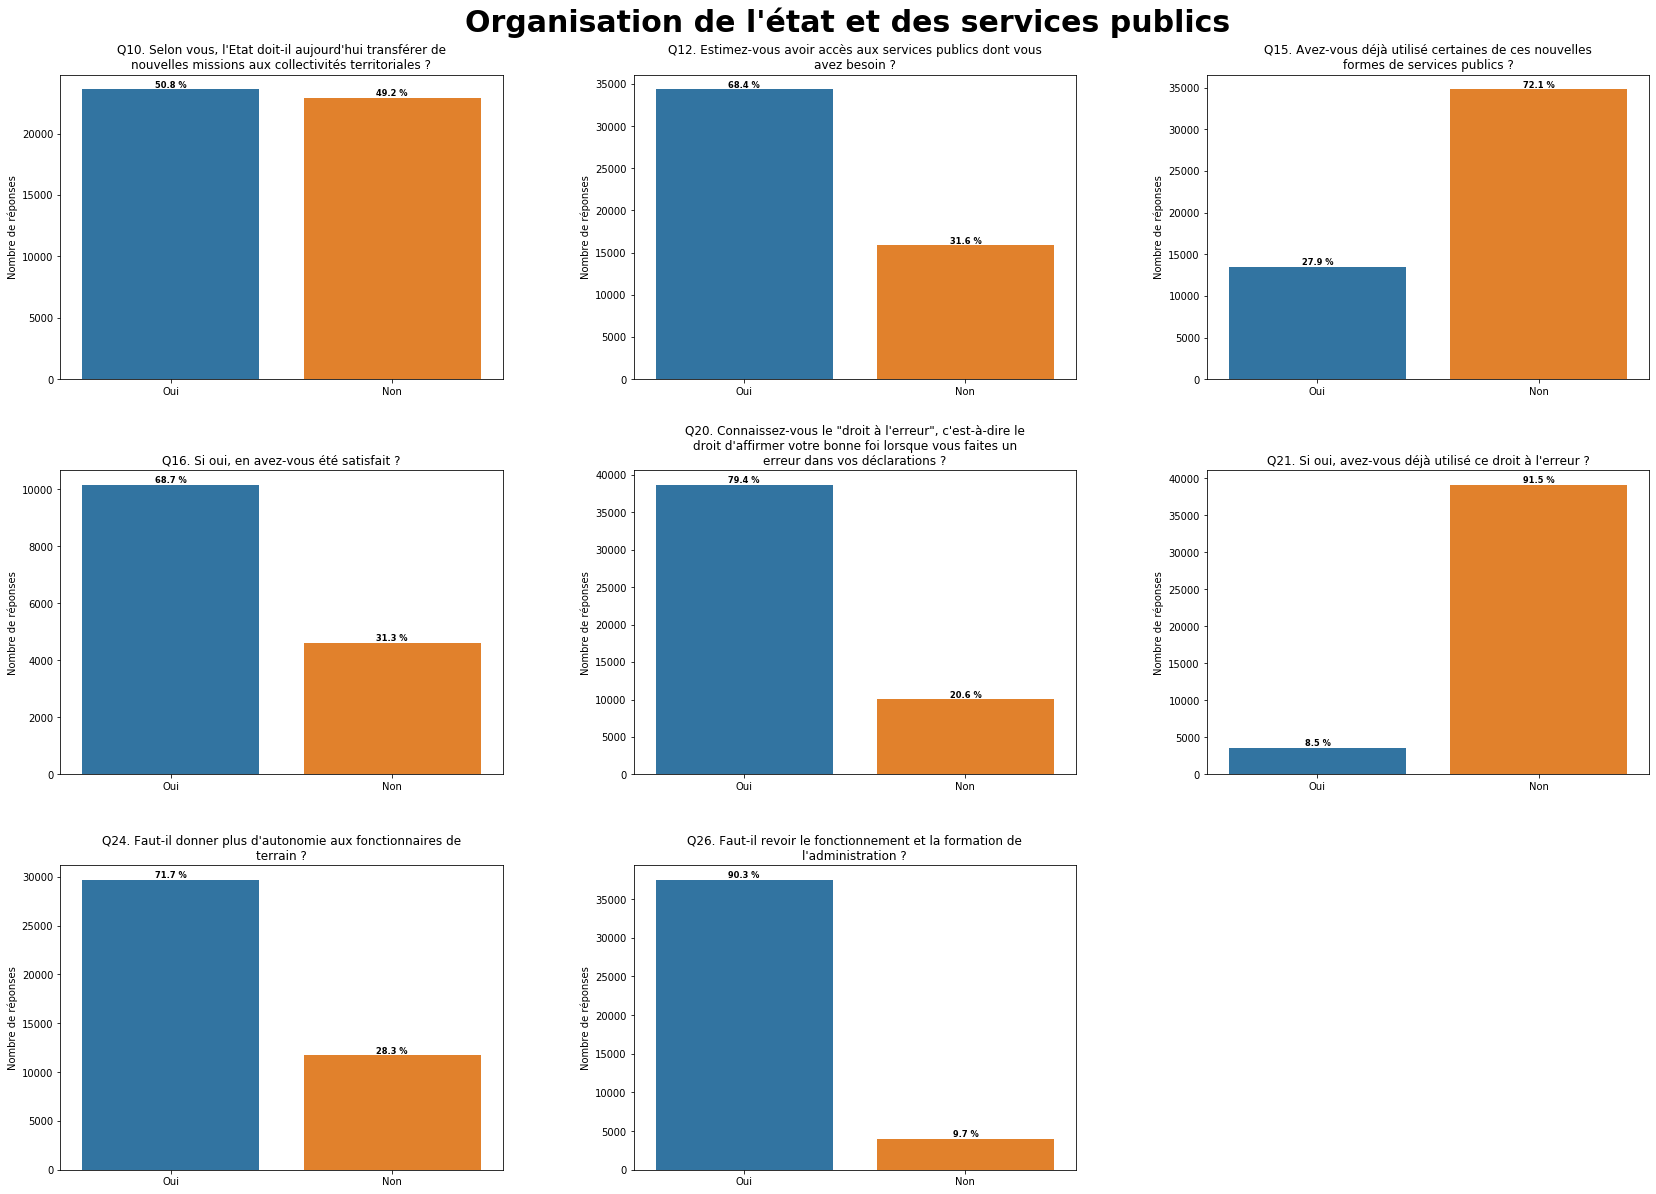

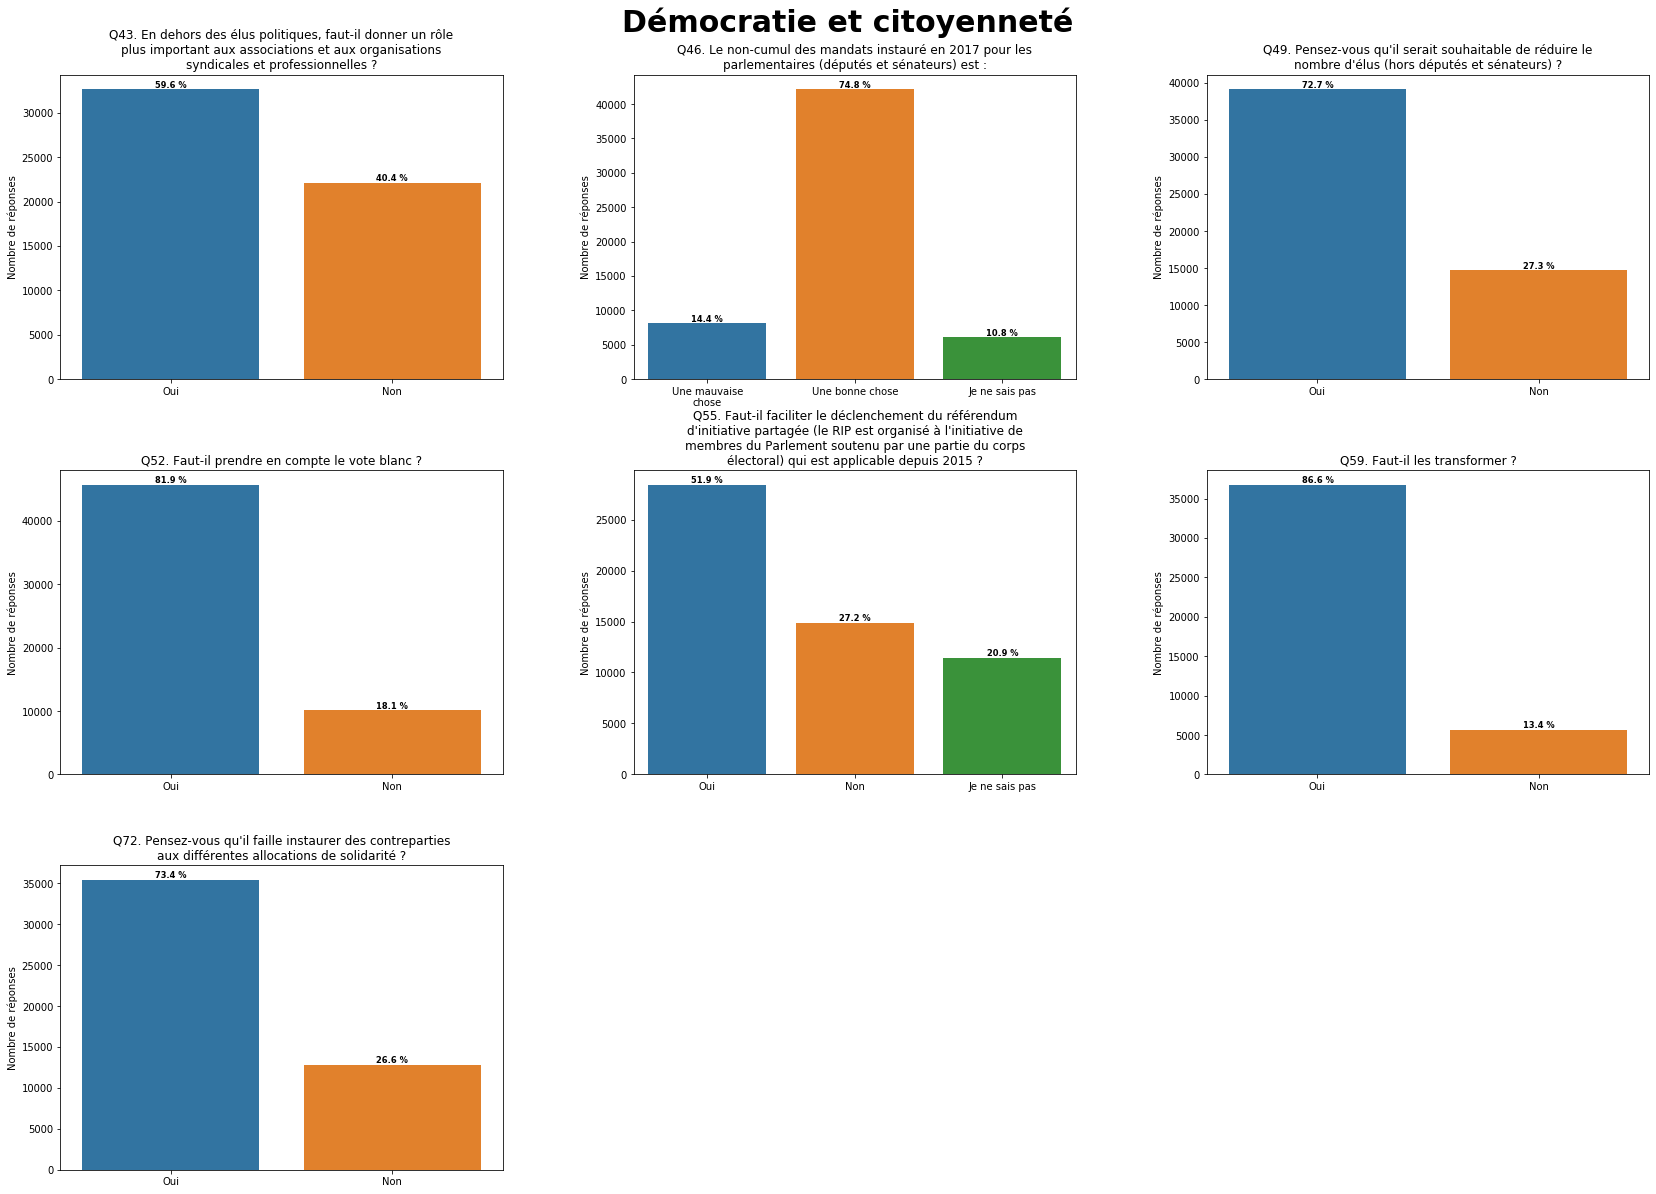

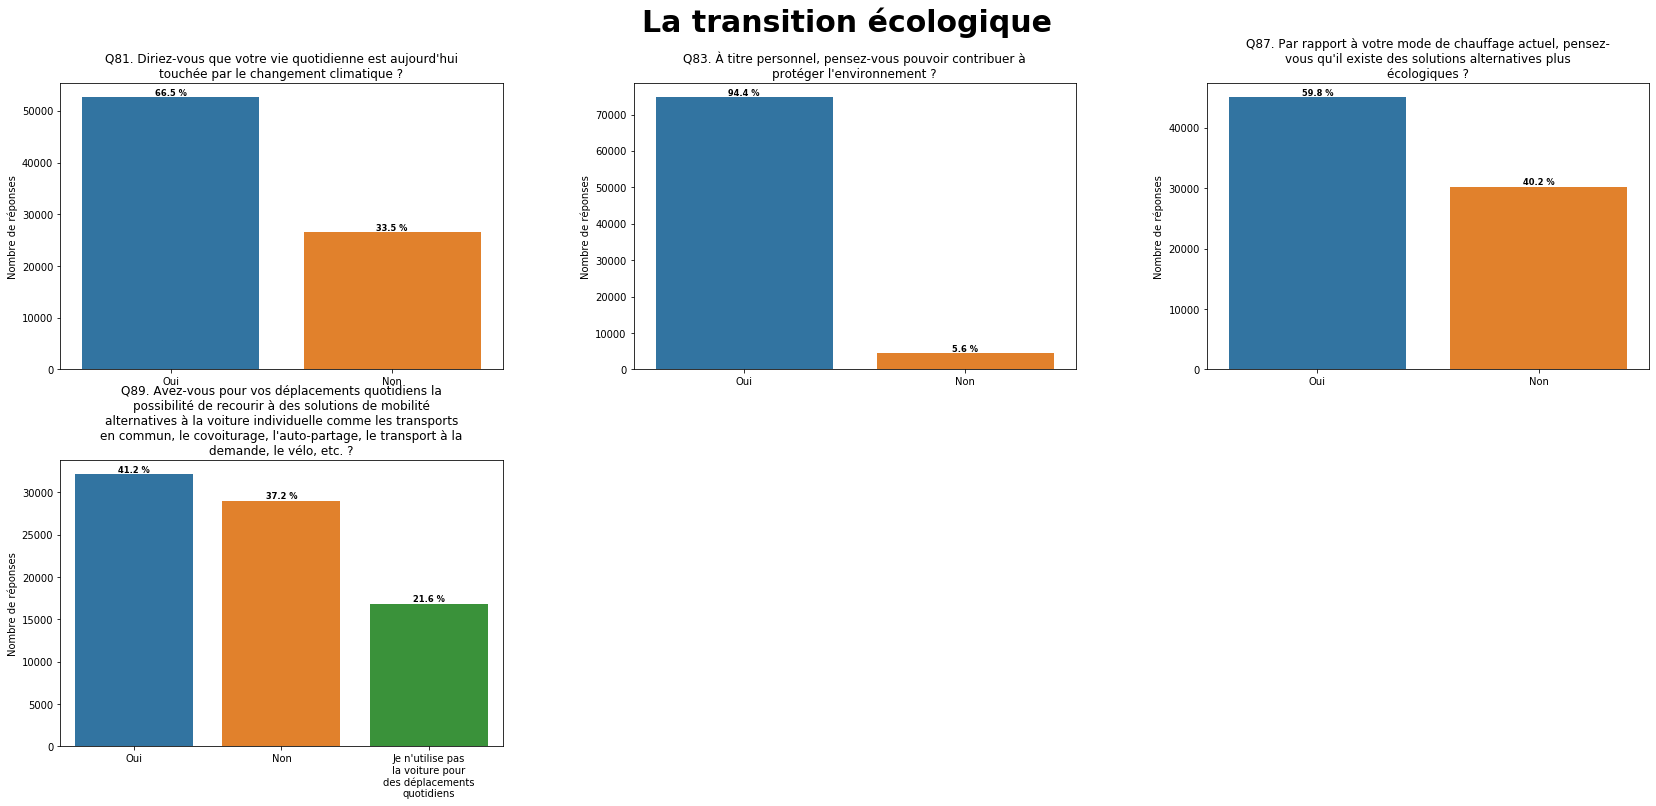

In [0]:
# Plotting questions, grouped by theme
for i in range(len(themes)):
    countplot_qdf(questions[(questions.closed) & (questions.df_id == i)].reset_index(), themes[i])


On the themes of State organisation, democracy and citizenship: when asked their opinion, contributors always take side for change.

It's very interesting to see all these opinions.

### Open questions analysis

Most of the information of the dataset lies in the open questions, but they are the most difficult to analysis!

We can start with with a basic statistic, the number of words contained in the whole dataset.

In [0]:
# Count words in a string, a word being here any sequence of characters between white spaces
def count_words(s):
    if s is np.nan:
        return(0)
    return(len(s.split()))

In [0]:
# For each dataframe:
# filter on questions and title
# count words for each contribution of each question
# sum it all
n_words = [df.filter(regex=r'title|^Q', axis=1).apply(np.vectorize(count_words)).sum().sum()\
           for df in df_list]
sum(n_words)


94052931

The contributions contain 95 million words!

Let's focus on the 75 open questions. 
We first remove all stop words, those are the most common words that don't give any insight, and must be filtered out when doing natural language processing.

In [0]:
stop_words = [unidecode.unidecode(w.lower()) for w in stops]
# Add punctuation and some missing stopwords using this website : https://www.ranks.nl/stopwords/french
stop_words = set(stop_words +
                 list(string.punctuation) +
                 ["’", "...", "'", "", ">>", "<<"] +
                 ["oui", "non", "plus", "toute", "toutes", "faut","à","tous","tandis","quels",
                  "alors","au","aucuns","aussi","autre","avant","avec","avoir","juste","la","tout","toutes","très","trop",
"www","http","html","peu","en","etc","chaque","sans","ne","ils","il","que","quand","quoi","qui","plupart",
"doit","donc","dos","elle","elles","comme","comment","ci","ni","même","mais","mes","aussi","alors","an","je","ça","où","org","moi"
                 
                 ])

The next important step is to run a tokenization, i.e. splitting text into words. This might be tricky because of punctuation, wich is slightly different according to the language. There are some important features we have to take into considreation: punctuation, case, encoding and stop words.

In [0]:
# Get tokens from list of strings (can probably be optimised)
def get_tokens(s):
    # MosesTokenizer has been moved out of NLTK due to licensing issues
    # So we define a simple tokenizer based on regex, designed for French language
    pattern = r"[cdjlmnstCDJLMNST]['´`]|\w+|\$[\d\.]+|\S+"
    tokenizer = RegexpTokenizer(pattern)
    tokens = tokenizer.tokenize(" ".join(s.dropna()))
    # remove punctuation (for words like "j'")
    tokens = [w.translate(str.maketrans('', '', string.punctuation)) for w in tokens]
    # lowercase ASCII
    tokens = [unidecode.unidecode(w.lower()) for w in tokens]
    # remove stop words from tokens
    tokens = [w for w in tokens if w not in stop_words]
    return(tokens)

We will use the tokens to draw a word cloud. This is a visual representation of n-gram counts. The more frequent a term is, the bigger it will appear on the plot.

Let's plot a wordcloud for each of the 4 themes. We will see what are the most raised topics among each of them.

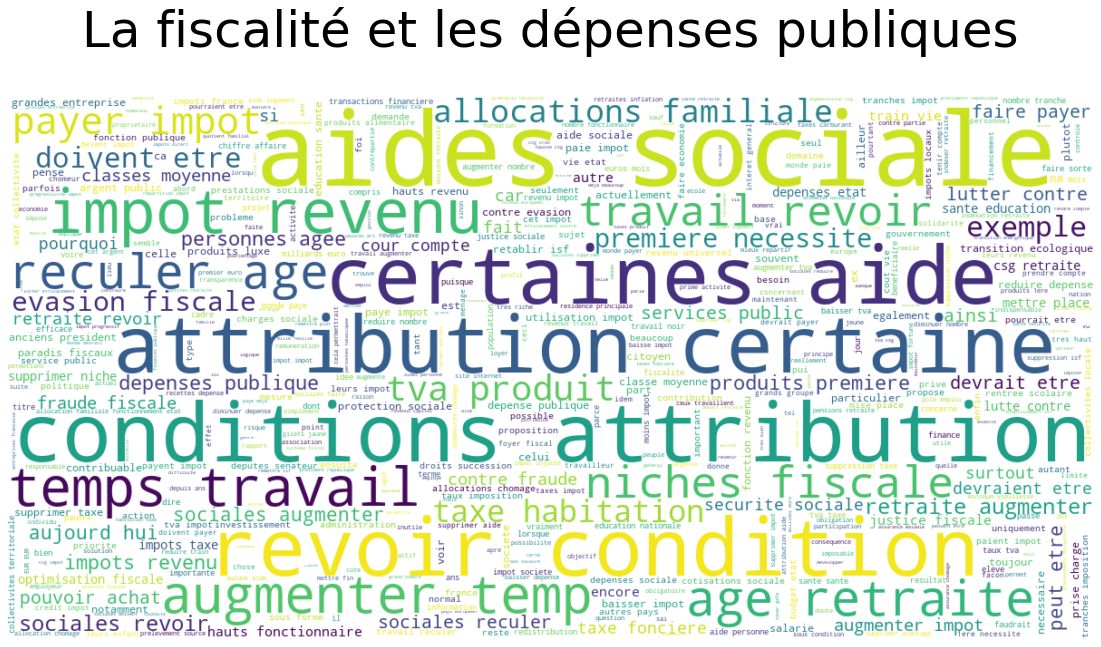

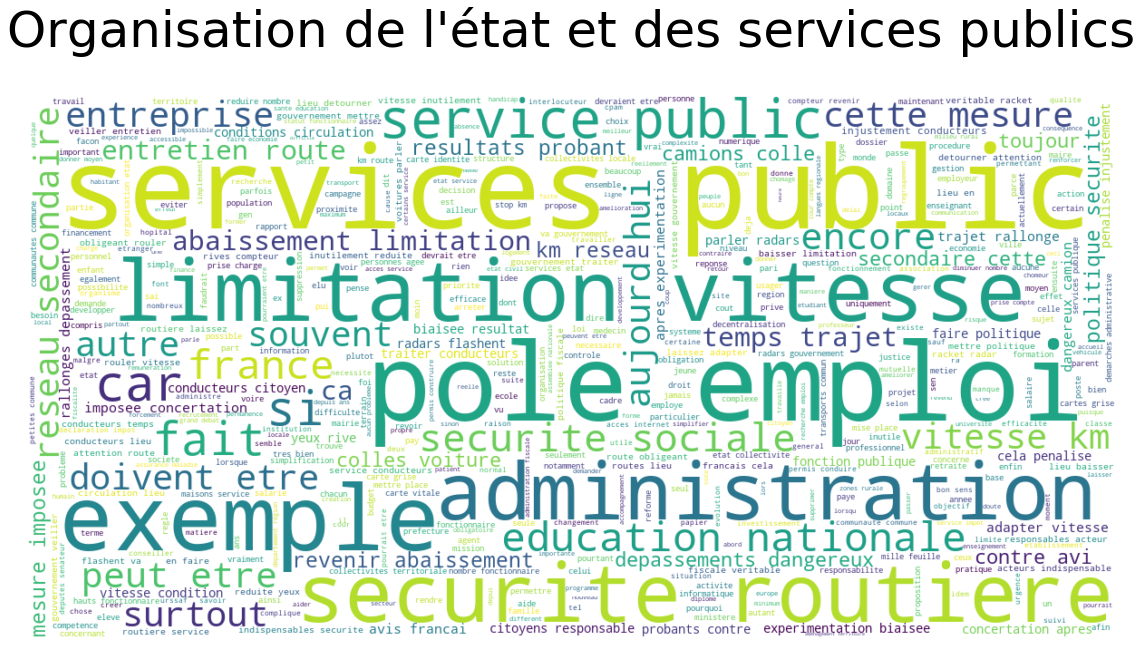

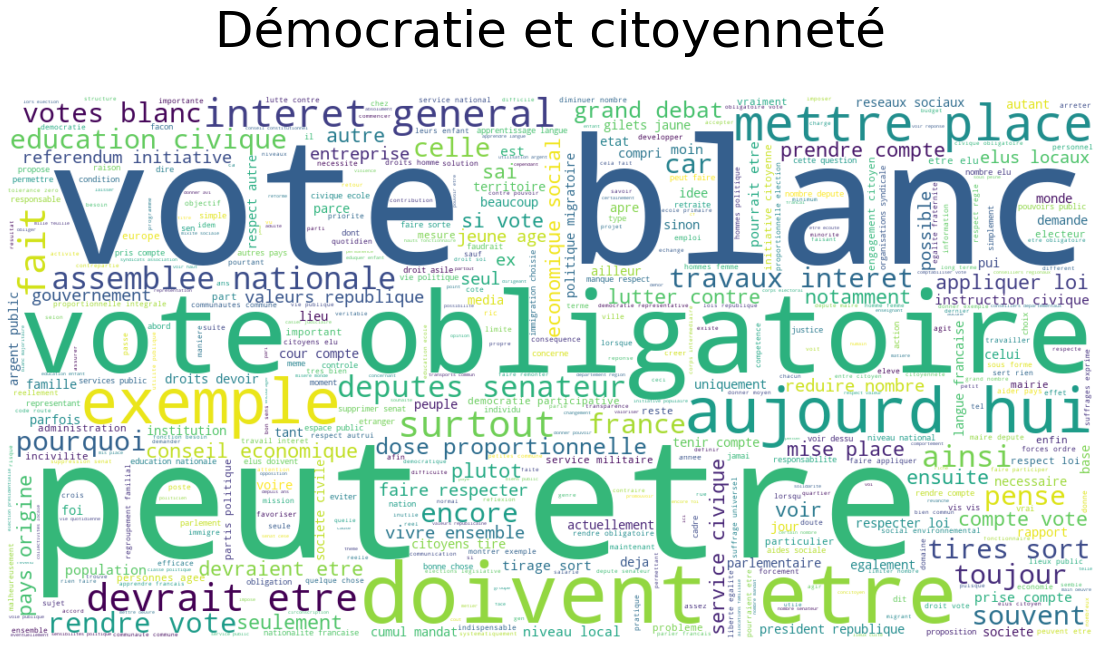

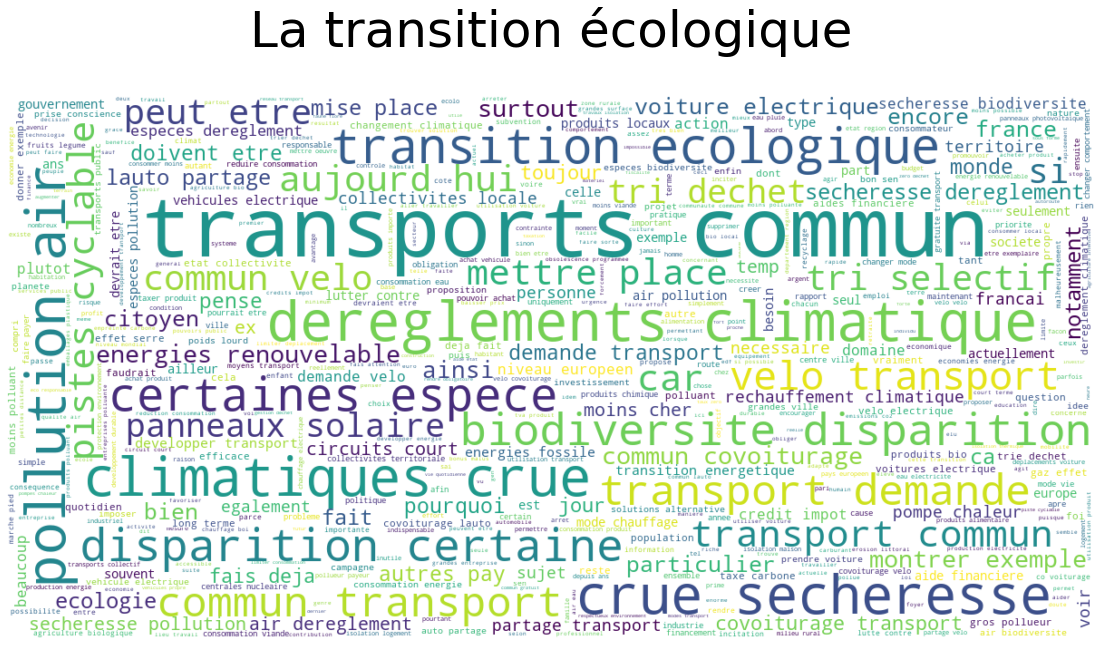

In [0]:
def plot_wordcloud(s, title, mw = 500):
    wordcloud = WordCloud(width=1200, height=600, max_words=mw,
                          background_color="white").generate(" ".join(s))
    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=50, pad=50)
    plt.show()

col_q = questions.new_name[~questions.closed].append(pd.Series('title'))
for i in range(len(themes)):
    col_q_i = df_list[i].columns.intersection(col_q)
    tokens = pd.concat([df_list[i][col].dropna() for col in col_q_i])
    tokens = get_tokens(tokens)
    plot_wordcloud(tokens, title = themes[i])

## Let's start with La fiscalité et les dépenses publiques

In [0]:
df_list[0] = df_list[0].astype(str) 

#contains all the answers of questions 1 to 8
reponse_question1 = df_list[0].Q1
reponse_question2 = df_list[0].Q2
reponse_question3 = df_list[0].Q3
reponse_question4 = df_list[0].Q4
reponse_question5 = df_list[0].Q5
reponse_question6 = df_list[0].Q6
reponse_question7 = df_list[0].Q7
reponse_question8 = df_list[0].Q8

### Let's have a look at the different possible answer

In [0]:
reponse_question1.value_counts().head(10)


nan                     34462
Plus de transparence       96
plus de transparence       72
Transparence               70
La transparence            65
?                          63
Je ne sais pas             60
RAS                        59
transparence               55
je ne sais pas             55
Name: Q1, dtype: int64

In [0]:
reponse_question2.value_counts().head(10)


nan                                                                                                                                                                                                                                                                          19749
Supprimer la CSG pour TOUS les retraités. Supprimer la taxe d'habitation pour tous les retraités.                                                                                                                                                                               84
Rétablir l'ISF                                                                                                                                                                                                                                                                  73
Supprimer les niches fiscales                                                                                                                                                  

In [0]:
reponse_question3.value_counts().head(10)


nan                     27862
TVA                      1361
La TVA                    701
Impôt sur le revenu       616
la TVA                    590
Aucun                     576
CSG                       417
aucun                     407
Impôts sur le revenu      366
Tous                      280
Name: Q3, dtype: int64

In [0]:
reponse_question4.value_counts().head(10)


nan                                                                                                                           19203
Revoir les conditions d'attribution de certaines aides sociales                                                               15456
Augmenter le temps de travail|Revoir les conditions d'attribution de certaines aides sociales                                  4462
Reculer l'âge de la retraite|Augmenter le temps de travail|Revoir les conditions d'attribution de certaines aides sociales     4282
Reculer l'âge de la retraite|Revoir les conditions d'attribution de certaines aides sociales                                   2722
Revoir les conditions d'attribution de certaines aides sociales|Augmenter le temps de travail                                  1844
Augmenter le temps de travail                                                                                                  1707
Reculer l'âge de la retraite|Augmenter le temps de travail                  

# Pretreatments

In [0]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nathanamar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
def preprocess_text(test):

  

    #test = test.lower()
    #Removing Numbers
    test=re.sub(r'\d+','',test)

    
    #Removing white spaces
    test=test.strip()
    
    #Replacer replace
    text_replaced = replacer.replace(test)

      #Tokenize
    tokenizer=nltk.data.load('tokenizers/punkt/french.pickle')
    sentences = tokenizer.tokenize(text_replaced)

     #Tokenize words
    tokenizer = WordPunctTokenizer()
    for i in range(len(sentences)):
        sentences[i] = tokenizer.tokenize(sentences[i])
        
     #Remove stop words


    for i in range(len(sentences)):
        sentences[i] = [word for word in sentences[i] if word not in stop_words]

    for i in range(len(sentences)):
        for j in range(len(sentences[i])):
            sentences[i][j] = lemmatizer.lemmatize(sentences[i][j])


    #Join the words back into a sentence.
    a=[' '.join(s) for s in sentences]
    b=['. '.join(a)]

    return b

In [0]:
reponse_question1_cleaned = [preprocess_text(doc) for doc in reponse_question1]
reponse_question1 = [' '.join(r) for r in reponse_question1_cleaned]


reponse_question2_cleaned = [preprocess_text(doc) for doc in reponse_question2]
reponse_question2 = [' '.join(r) for r in reponse_question2_cleaned]


reponse_question3_cleaned = [preprocess_text(doc) for doc in reponse_question3]
reponse_question3 = [' '.join(r) for r in reponse_question3_cleaned]


reponse_question4_cleaned = [preprocess_text(doc) for doc in reponse_question4]
reponse_question4 = [' '.join(r) for r in reponse_question4_cleaned]

reponse_question5_cleaned = [preprocess_text(doc) for doc in reponse_question5]
reponse_question5 = [' '.join(r) for r in reponse_question5_cleaned]


reponse_question6_cleaned = [preprocess_text(doc) for doc in reponse_question6]
reponse_question6 = [' '.join(r) for r in reponse_question6_cleaned]


reponse_question7_cleaned = [preprocess_text(doc) for doc in reponse_question7]
reponse_question7 = [' '.join(r) for r in reponse_question7_cleaned]


reponse_question8_cleaned = [preprocess_text(doc) for doc in reponse_question8]
reponse_question8 = [' '.join(r) for r in reponse_question8_cleaned]

In [0]:
!pip install pyLdavis

In [0]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk
from pprint import pprint

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

STOP_WORDS = nltk.corpus.stopwords.words()

from gensim.utils import simple_preprocess
from smart_open import smart_open
import pyLDAvis.gensim # To visualise LDA model effectively

import os
from collections import defaultdict # For accumlating values
from nltk.corpus import stopwords # To remove stopwords
from gensim import corpora # To create corpus and dictionary for the LDA model
from gensim.models import LdaModel # To use the LDA model

# Unsupervised analysis

# Let's start with La fiscalité et les dépenses publiques

In [0]:
reponse1 = pd.DataFrame(reponse_question1)
reponse1.columns = ['Question1_Quelles sont toutes les choses qui pourraient être faites pour améliorer information des citoyens sur utilisation des impôts ?']
reponse1 = reponse1[reponse1['Question1_Quelles sont toutes les choses qui pourraient être faites pour améliorer information des citoyens sur utilisation des impôts ?']!= 'nan']
reponse1.head()


Question1_Quelles sont toutes les choses qui pourraient être faites pour améliorer information des citoyens sur utilisation des impôts ?
5   proposition refondation capitalisme instauration dividende Universel Financées épargne. En démocratie peuple souverain élit représentant compétents incompétent mérite fait propre compétence incompétence. Sans nommer Macron expliqué « gilet jaune » départ réclamaient pouvoir achat révolté entre a...
8                                                                                                                                                                                                                                                                                   faire bulletin info souvent
12                                                                                                                                                                                                                                         supprimer tranche imposition remplacer taux unique appliquant revenu
14                                                                                                                                                                                                                                                                   Commencer dire € dépense emprunter moins €
15                                                                                                                                                                                                                           Il chacun paye directement impot dont identifie utilisation impôt communal commune

In [0]:
# Create gensim dictionary form a single tet file
dictionary= corpora.Dictionary(simple_preprocess(line, deacc=True) for line in reponse1['Question1_Quelles sont toutes les choses qui pourraient être faites pour améliorer information des citoyens sur utilisation des impôts ?'])

# Token to Id map
dictionary.token2id

{'absolu': 0,
 'achat': 1,
 'activite': 2,
 'ainsi': 3,
 'alourdissant': 4,
 'an': 5,
 'apporter': 6,
 'article': 7,
 'au': 8,
 'autres': 9,
 'banque': 10,
 'bien': 11,
 'cac': 12,
 'capital': 13,
 'capitalisme': 14,
 'capitaliste': 15,
 'cette': 16,
 'ceux': 17,
 'classe': 18,
 'clef': 19,
 'competence': 20,
 'competents': 21,
 'contraire': 22,
 'contre': 23,
 'croient': 24,
 'crois': 25,
 'croissance': 26,
 'de': 27,
 'decouleraient': 28,
 'demeurera': 29,
 'democratie': 30,
 'depart': 31,
 'depense': 32,
 'des': 33,
 'detenir': 34,
 'dette': 35,
 'disparaitra': 36,
 'disparaitrait': 37,
 'dividende': 38,
 'dizaine': 39,
 'douleur': 40,
 'economique': 41,
 'economiquement': 42,
 'elire': 43,
 'elit': 44,
 'en': 45,
 'encore': 46,
 'entre': 47,
 'entreprise': 48,
 'epargne': 49,
 'esperer': 50,
 'et': 51,
 'euro': 52,
 'europeen': 53,
 'explique': 54,
 'fait': 55,
 'fin': 56,
 'finance': 57,
 'financees': 58,
 'fiscalite': 59,
 'francais': 60,
 'gilet': 61,
 'humanisme': 62,
 'incluse

In [0]:
# Tokenize the docs
tokenized_list = [simple_preprocess(doc) for doc in reponse1['Question1_Quelles sont toutes les choses qui pourraient être faites pour améliorer information des citoyens sur utilisation des impôts ?']]
mydict = corpora.Dictionary()
mycorpus = [mydict.doc2bow(doc, allow_update=True) for doc in tokenized_list]

In [0]:
NUM_TOPICS = 10 # This is an assumption. 
ldamodel = LdaModel(mycorpus, num_topics = NUM_TOPICS, id2word=mydict, passes=15)#This might take some time.

In [0]:
topics = ldamodel.show_topics()
for topic in topics:
    print(topic)


(0, '0.072*"impôt" + 0.051*"argent" + 0.028*"expliquer" + 0.019*"va" + 0.015*"utilisation" + 0.014*"il" + 0.014*"savoir" + 0.014*"servent" + 0.013*"public" + 0.013*"sert"')
(1, '0.016*"français" + 0.014*"pays" + 0.014*"être" + 0.014*"citoyen" + 0.013*"france" + 0.013*"impôt" + 0.011*"il" + 0.010*"faire" + 0.010*"autres" + 0.008*"économie"')
(2, '0.068*"information" + 0.048*"site" + 0.039*"internet" + 0.037*"impôt" + 0.032*"utilisation" + 0.024*"une" + 0.018*"communication" + 0.015*"simple" + 0.014*"média" + 0.012*"un"')
(3, '0.059*"transparence" + 0.033*"dépense" + 0.031*"élu" + 0.027*"fonctionnaire" + 0.020*"salaire" + 0.016*"plus" + 0.015*"haut" + 0.015*"avantage" + 0.015*"président" + 0.013*"frai"')
(4, '0.080*"compte" + 0.041*"cour" + 0.031*"niveau" + 0.030*"rendre" + 0.027*"commune" + 0.025*"public" + 0.023*"rapport" + 0.022*"région" + 0.020*"citoyen" + 0.015*"département"')
(5, '0.045*"service" + 0.044*"coût" + 0.025*"santé" + 0.024*"public" + 0.023*"éducation" + 0.021*"sociale" 

In [0]:
word_dict = {};
for i in range(NUM_TOPICS):
    words = ldamodel.show_topic(i, topn = 15)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)


Topic # 01 Topic # 02     Topic # 03     Topic # 04    Topic # 05  \
0         impôt   français    information   transparence        compte   
1        argent       pays           site        dépense          cour   
2     expliquer       être       internet            élu        niveau   
3            va    citoyen          impôt  fonctionnaire        rendre   
4   utilisation     france    utilisation        salaire       commune   
5            il      impôt            une           plus        public   
6        savoir         il  communication           haut       rapport   
7       servent      faire         simple       avantage        région   
8        public     autres          média      président       citoyen   
9          sert   économie             un           frai   département   
10      citoyen    système         claire           état      national   
11         euro    service         impots         député         rendu   
12         fait      monde            des       ministre   utilisation   
13      exemple  fiscalité           gouv         totale  collectivité   
14      utilisé      entre        citoyen      politique        locale   

   Topic # 06    Topic # 07   Topic # 08   Topic # 09  Topic # 10  
0     service         impôt         être      dépense  entreprise  
1        coût          taxe           il       budget    retraite  
2       santé        revenu         cela         état        euro  
3      public   utilisation         peut        année        aide  
4   éducation   déclaration        faire      recette          an  
5     sociale    imposition         bien        bilan      emploi  
6       école           tva  information    publiques         les  
7        aide       montant           si         etat     travail  
8     citoyen      fiscales         fait        poste    personne  
9     exemple   répartition          les      publier     sociale  
10   sécurité   prélèvement         déjà       annuel     salaire  
11      impôt          avis         rien        grand          de  
12       état    simplifier           je  répartition      france  
13      année  contribution      citoyen    ministère         moi  
14    hôpital       feuille           le       détail     fiscale

In [0]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, mycorpus, mydict, sort_topics=False)
pyLDAvis.display(lda_display)

/Users/nathanamar/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


## Interpretation 

Avant de commenter notre tableau, on peut voir avec un value_counts() qu'une des choses qui pourraient être faites pour améliorer information des citoyens sur utilisation des impôts est bien la transparence. Ce qui resort sont les médias ou des sites publiques dédiés à l’utilisation des impôts bien expliquer avec des informations concrètes seraient bénéfiques. Il faut faire des debats, partager l'information via la tv, les journaux et des emissions. Mais surtout etre transparent, il faudrait des forme simples. On peut voir également une sorte de plainte au niveauu des avantages des salaires de haut fonctionnaires travaillant dans la politique.

## Let's analyze question 2 : Que faudrait-il faire pour rendre la fiscalité plus juste et plus efficace ?

In [0]:
reponse2 = pd.DataFrame(reponse_question2)
reponse2.columns = ['Question_2_Que faudrait-il faire pour rendre la fiscalité plus juste et plus efficace ?']
reponse2 = reponse2[reponse2['Question_2_Que faudrait-il faire pour rendre la fiscalité plus juste et plus efficace ?']!= 'nan']

reponse2.head()


Question_2_Que faudrait-il faire pour rendre la fiscalité plus juste et plus efficace ?
3                                                                     Repartir richesse. suppression taxe habitation français csg reindexé retraite. Ne diviser français patron besoin modestes vice versa. Les patron réussisses si modestes. Les français veulent assistanat veulent vivre dignement salaire
4                                                                                                                                                                                                                                                                    Les droit automatique devoir payer impots
7                                                                                                                                                                                           réduire drastiquement fraude fiscale. Imposer grand groupe GAFA suffisamment Renforcer taxe transaction financière
8                                                                                                                                                                                                                                                     diminuer taux prelevement retraité percevant minute euro
9  tout français DEVRA PAYER L impôt QU IL SOIT DOMICILIÉ OU non EN FRANCE LES français NE VOULANT plus PAYER L IMPOT EN FRANCE DEVRONT CHANGER DE nationalité. L IMPOT DEVRA ETRE progressif EGALEMENT pour LES artiste ET LES chef D entreprise LES sportif ETC la fiscalité DEVRA ETRE FIXÉE DANS LES si...

In [0]:
# Create gensim dictionary form a single tet file
dictionary= corpora.Dictionary(simple_preprocess(line, deacc=True) for line in reponse2['Question_2_Que faudrait-il faire pour rendre la fiscalité plus juste et plus efficace ?'])

# Token to Id map
dictionary.token2id

{'assistanat': 0,
 'besoin': 1,
 'csg': 2,
 'dignement': 3,
 'diviser': 4,
 'francais': 5,
 'habitation': 6,
 'les': 7,
 'modestes': 8,
 'ne': 9,
 'patron': 10,
 'reindexe': 11,
 'repartir': 12,
 'retraite': 13,
 'reussisses': 14,
 'richesse': 15,
 'salaire': 16,
 'si': 17,
 'suppression': 18,
 'taxe': 19,
 'versa': 20,
 'veulent': 21,
 'vice': 22,
 'vivre': 23,
 'automatique': 24,
 'devoir': 25,
 'droit': 26,
 'impots': 27,
 'payer': 28,
 'drastiquement': 29,
 'financiere': 30,
 'fiscale': 31,
 'fraude': 32,
 'gafa': 33,
 'grand': 34,
 'groupe': 35,
 'imposer': 36,
 'reduire': 37,
 'renforcer': 38,
 'suffisamment': 39,
 'transaction': 40,
 'diminuer': 41,
 'euro': 42,
 'minute': 43,
 'percevant': 44,
 'prelevement': 45,
 'taux': 46,
 'abattement': 47,
 'affaire': 48,
 'apres': 49,
 'art': 50,
 'artiste': 51,
 'assemblee': 52,
 'au': 53,
 'avoir': 54,
 'bijou': 55,
 'changer': 56,
 'chef': 57,
 'chiffre': 58,
 'comme': 59,
 'constitution': 60,
 'dans': 61,
 'de': 62,
 'des': 63,
 'devr

In [0]:
# Tokenize the docs
tokenized_list = [simple_preprocess(doc) for doc in reponse2['Question_2_Que faudrait-il faire pour rendre la fiscalité plus juste et plus efficace ?']]

# Create the Corpus
mydict = corpora.Dictionary()
mycorpus = [mydict.doc2bow(doc, allow_update=True) for doc in tokenized_list]

In [0]:
NUM_TOPICS = 10 # This is an assumption. 
ldamodel = LdaModel(mycorpus, num_topics = NUM_TOPICS, id2word=mydict, passes=15)#This might take some time.

In [0]:
topics = ldamodel.show_topics()
for topic in topics:
    print(topic)

(0, '0.118*"tva" + 0.094*"produit" + 0.036*"taxe" + 0.029*"nécessité" + 0.027*"première" + 0.027*"luxe" + 0.026*"augmenter" + 0.020*"baisser" + 0.017*"taux" + 0.014*"taxer"')
(1, '0.092*"impôt" + 0.063*"revenu" + 0.048*"monde" + 0.037*"payer" + 0.030*"citoyen" + 0.023*"que" + 0.020*"faire" + 0.017*"chacun" + 0.016*"être" + 0.016*"euro"')
(2, '0.018*"être" + 0.011*"fiscalité" + 0.011*"il" + 0.011*"la" + 0.008*"cette" + 0.007*"impôt" + 0.007*"bien" + 0.006*"cela" + 0.006*"état" + 0.006*"si"')
(3, '0.056*"fiscale" + 0.050*"entreprise" + 0.034*"contre" + 0.033*"taxer" + 0.026*"fraude" + 0.025*"évasion" + 0.023*"grand" + 0.020*"lutter" + 0.019*"fiscal" + 0.016*"optimisation"')
(4, '0.061*"retraite" + 0.035*"retraité" + 0.029*"csg" + 0.026*"taxe" + 0.024*"supprimer" + 0.021*"cotisation" + 0.020*"charge" + 0.018*"sociale" + 0.017*"salarié" + 0.017*"salaire"')
(5, '0.028*"dépense" + 0.023*"avantage" + 0.021*"fonctionnaire" + 0.019*"élu" + 0.017*"les" + 0.014*"réduire" + 0.013*"supprimer" + 0.0

In [0]:
word_dict = {};
for i in range(NUM_TOPICS):
    words = ldamodel.show_topic(i, topn = 15)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

Topic # 01  Topic # 02 Topic # 03    Topic # 04    Topic # 05  \
0            tva       impôt       être       fiscale      retraite   
1        produit      revenu  fiscalité    entreprise      retraité   
2           taxe       monde         il        contre           csg   
3      nécessité       payer         la         taxer          taxe   
4       première     citoyen      cette        fraude     supprimer   
5           luxe         que      impôt       évasion    cotisation   
6      augmenter       faire       bien         grand        charge   
7        baisser      chacun       cela        lutter       sociale   
8           taux        être       état        fiscal       salarié   
9          taxer        euro         si  optimisation       salaire   
10  consommation        paye         le         faire    habitation   
11       voiture  symbolique       peut      bénéfice            an   
12          prix        tout        les          gafa       pension   
13      diminuer        paie    citoyen      européen  augmentation   
14     carburant    français   économie       paradis           vie   

       Topic # 06 Topic # 07  Topic # 08   Topic # 09  Topic # 10  
0         dépense   personne      france     fiscales      revenu  
1        avantage       aide    français        niche       impôt  
2   fonctionnaire     enfant       impôt          isf     tranche  
3             élu       ceux        pays    supprimer  imposition  
4             les         il    étranger        impôt        taux  
5         réduire      moins  entreprise     rétablir        taxe  
6       supprimer        car       leurs       classe         csg  
7              de     argent       payer      moyenne   augmenter  
8            état         si   résidence        riche        aide  
9         salaire       cela     société  suppression  progressif  
10      président      faire        taxe     remettre      nombre  
11           haut       bien    personne        taxer        haut  
12         compte       fait  territoire       revoir        euro  
13            des    travail     doivent   simplifier       seuil  
14         député      payer    européen      arrêter     sociale

## Interprétation
Il faudrait diminuer le prix du carburant, faire attention à l'évasion fiscale.S upprimer la CSG pour tous les retraités ainsi que la taxe d'habitation. Il faudrait également selon eux rétablir l'ISF.On peut voir qu'il faut supprimer la CSG. Il faut faire attention à l'évasion fiscale également. Il faudrait également supprimer les niches fiscales et réduire les avantages des hauts fonctionnaires.

##  Let's focus on question 3 :  Quels sont selon vous les impôts qu'il faut baisser en priorité ?

In [0]:
reponse3 = pd.DataFrame(reponse_question3)
reponse3.columns = ['Question_3_Quels sont selon vous les impôts qui faut baisser en priorité ?']
reponse3 = reponse3[reponse3['Question_3_Quels sont selon vous les impôts qui faut baisser en priorité ?']!= 'nan']

In [0]:
# Create gensim dictionary form a single tet file
dictionary= corpora.Dictionary(simple_preprocess(line, deacc=True) for line in reponse3['Question_3_Quels sont selon vous les impôts qui faut baisser en priorité ?'])

# Token to Id map
dictionary.token2id

{'csg': 0,
 'habitation': 1,
 'taxe': 2,
 'compris': 3,
 'impots': 4,
 'retraite': 5,
 'salaire': 6,
 'le': 7,
 'revenu': 8,
 'sur': 9,
 'impot': 10,
 'citoyen': 11,
 'egal': 12,
 'applique': 13,
 'condition': 14,
 'fonciere': 15,
 'fusion': 16,
 'ifi': 17,
 'isf': 18,
 'occupant': 19,
 'parait': 20,
 'parfaire': 21,
 'production': 22,
 'ressource': 23,
 'sou': 24,
 'suppression': 25,
 'alimentation': 26,
 'augmenter': 27,
 'baisser': 28,
 'beurre': 29,
 'bijou': 30,
 'certain': 31,
 'fruit': 32,
 'lait': 33,
 'legume': 34,
 'luxe': 35,
 'necessite': 36,
 'oeuf': 37,
 'pain': 38,
 'parfum': 39,
 'premiere': 40,
 'produit': 41,
 'tva': 42,
 'alimentaire': 43,
 'eau': 44,
 'electricite': 45,
 'gaz': 46,
 'haut': 47,
 'plius': 48,
 'supprimer': 49,
 'voir': 50,
 'charge': 51,
 'travail': 52,
 'afin': 53,
 'chacun': 54,
 'devrait': 55,
 'exister': 56,
 'injuste': 57,
 'la': 58,
 'nourrir': 59,
 'puisse': 60,
 'rds': 61,
 'baisse': 62,
 'embauche': 63,
 'employeur': 64,
 'indirects': 65,
 '

In [0]:
# Tokenize the docs
tokenized_list = [simple_preprocess(doc) for doc in reponse3['Question_3_Quels sont selon vous les impôts qui faut baisser en priorité ?']]
mydict = corpora.Dictionary()
mycorpus = [mydict.doc2bow(doc, allow_update=True) for doc in tokenized_list]


In [0]:
NUM_TOPICS = 10 # This is an assumption. 
ldamodel = LdaModel(mycorpus, num_topics = NUM_TOPICS, id2word=mydict, passes=15)#This might take some time.

In [0]:
topics = ldamodel.show_topics()
for topic in topics:
    print(topic)


(0, '0.285*"revenu" + 0.254*"impôt" + 0.046*"moyenne" + 0.042*"classe" + 0.035*"les" + 0.032*"impot" + 0.029*"tranche" + 0.023*"impots" + 0.017*"sur" + 0.013*"travail"')
(1, '0.157*"csg" + 0.054*"retraité" + 0.047*"retraite" + 0.033*"supprimer" + 0.031*"la" + 0.024*"euro" + 0.013*"augmentation" + 0.012*"crds" + 0.011*"irpp" + 0.011*"hausse"')
(2, '0.034*"impôt" + 0.024*"être" + 0.014*"si" + 0.013*"payer" + 0.013*"il" + 0.012*"faire" + 0.011*"baisser" + 0.010*"car" + 0.009*"bien" + 0.009*"je"')
(3, '0.231*"tva" + 0.172*"produit" + 0.090*"nécessité" + 0.079*"première" + 0.069*"la" + 0.016*"luxe" + 0.016*"alimentaires" + 0.014*"base" + 0.014*"baisser" + 0.012*"alimentation"')
(4, '0.215*"taxe" + 0.100*"habitation" + 0.043*"supprimer" + 0.038*"succession" + 0.038*"foncière" + 0.028*"droit" + 0.025*"foncier" + 0.023*"suppression" + 0.019*"la" + 0.017*"les"')
(5, '0.061*"impôt" + 0.054*"baisser" + 0.037*"il" + 0.035*"aucun" + 0.030*"dépense" + 0.025*"locaux" + 0.017*"réduire" + 0.015*"baisse

In [0]:
word_dict = {};
for i in range(NUM_TOPICS):
    words = ldamodel.show_topic(i, topn = 15)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

Topic # 01    Topic # 02 Topic # 03    Topic # 04   Topic # 05 Topic # 06  \
0       revenu           csg      impôt           tva         taxe      impôt   
1        impôt      retraité       être       produit   habitation    baisser   
2      moyenne      retraite         si     nécessité    supprimer         il   
3       classe     supprimer      payer      première   succession      aucun   
4          les            la         il            la     foncière    dépense   
5        impot          euro      faire          luxe        droit     locaux   
6      tranche  augmentation    baisser  alimentaires      foncier    réduire   
7       impots          crds        car          base  suppression     baisse   
8          sur          irpp       bien       baisser           la   fiscales   
9      travail        hausse         je  alimentation          les      mieux   
10     société          taux       peut     augmenter          ifi  augmenter   
11        ceux   suppression   français          taux    résidence      niche   
12   supérieur       pension      moins           ère   immobilier  supprimer   
13  progressif       salaire       fait           bio   principale    service   
14    modestes           moi      monde  consommation     logement       voir   

    Topic # 07    Topic # 08    Topic # 09      Topic # 10  
0      sociale          taxe       pouvoir      entreprise  
1       charge           tva         achat           impôt  
2      salaire     carburant            de            tous  
3          les           les          prix           petit  
4         aide       injuste          taux         travail  
5       enfant   électricité            le          emploi  
6      travail           eau          cela             les  
7   cotisation           gaz            et         société  
8         ceux     indirects        baisse             pme  
9     personne       énergie          pour          charge  
10  patronales           car         cette            ceux  
11         hui         fruit      économie  investissement  
12          ir       essence            en      production  
13     aujourd  consommation        france       favoriser  
14  salariales        légume  augmentation          direct

## Interprétation

Les impôts qui faut baisser en priorité sont la CSG des retraités, la TVA, ISF mais également l'impot sur le revenu. Les charges sociales pour les PME ainsi que la taxe habitation et la taxe fonciere. Il est vraiment tres interessant de voir ce que pense les français à travers cette analyse.

##  Let's focus on question 6 :  Quels sont les domaines prioritaires où notre protection sociale doit être renforcée ?

In [0]:
reponse6 = pd.DataFrame(reponse_question6)
reponse6.columns = ['Question6_Quels sont les domaines prioritaires où notre protection sociale doit être renforcée ?']
reponse6 = reponse6[reponse6['Question6_Quels sont les domaines prioritaires où notre protection sociale doit être renforcée ?']!= 'nan']
reponse6.head()

Question6_Quels sont les domaines prioritaires où notre protection sociale doit être renforcée ?
3                                                                                  santé. éducation
8                                                 remboursement total lunette dent appareil auditif
9                                                                   la fraude A la SECURITE sociale
12                                                                                           aucune
15                                                                                jetez cour pleine

In [0]:
dictionary= corpora.Dictionary(simple_preprocess(line, deacc=True) for line in reponse6['Question6_Quels sont les domaines prioritaires où notre protection sociale doit être renforcée ?'])

# Token to Id map
dictionary.token2id

{'education': 0,
 'sante': 1,
 'appareil': 2,
 'auditif': 3,
 'dent': 4,
 'lunette': 5,
 'remboursement': 6,
 'total': 7,
 'fraude': 8,
 'la': 9,
 'securite': 10,
 'sociale': 11,
 'aucune': 12,
 'cour': 13,
 'jetez': 14,
 'pleine': 15,
 'enfance': 16,
 'scolarite': 17,
 'hopital': 18,
 'handicap': 19,
 'ald': 20,
 'arrete': 21,
 'atteinte': 22,
 'bien': 23,
 'cancer': 24,
 'compter': 25,
 'creer': 26,
 'dit': 27,
 'etions': 28,
 'euro': 29,
 'faire': 30,
 'faudrait': 31,
 'femme': 32,
 'financiere': 33,
 'integrale': 34,
 'ma': 35,
 'niveau': 36,
 'notre': 37,
 'participation': 38,
 'poche': 39,
 'president': 40,
 'rembourses': 41,
 'un': 42,
 'aide': 43,
 'celles': 44,
 'controle': 45,
 'suppression': 46,
 'tricheur': 47,
 'dependance': 48,
 'aucunes': 49,
 'protection': 50,
 'cmu': 51,
 'attribuee': 52,
 'aujourd': 53,
 'chomage': 54,
 'duree': 55,
 'emploi': 56,
 'etre': 57,
 'hui': 58,
 'independant': 59,
 'minimum': 60,
 'perdent': 61,
 'sauf': 62,
 'vieillesse': 63,
 'service': 6

In [0]:
# Tokenize the docs
tokenized_list = [simple_preprocess(doc) for doc in reponse6['Question6_Quels sont les domaines prioritaires où notre protection sociale doit être renforcée ?']]
mydict = corpora.Dictionary()
mycorpus = [mydict.doc2bow(doc, allow_update=True) for doc in tokenized_list]

In [0]:
NUM_TOPICS = 10 # This is an assumption. 
ldamodel = LdaModel(mycorpus, num_topics = NUM_TOPICS, id2word=mydict, passes=15)#This might take some time.

In [0]:
topics = ldamodel.show_topics()
for topic in topics:
    print(topic)

(0, '0.082*"famille" + 0.072*"enfance" + 0.059*"aide" + 0.052*"enfant" + 0.039*"jeune" + 0.037*"allocation" + 0.026*"parent" + 0.026*"protection" + 0.024*"sante" + 0.021*"étudiant"')
(1, '0.223*"personne" + 0.087*"âgées" + 0.068*"handicapé" + 0.065*"aide" + 0.028*"les" + 0.027*"charge" + 0.025*"handicap" + 0.023*"prise" + 0.020*"dépendance" + 0.019*"agées"')
(2, '0.095*"sociale" + 0.059*"protection" + 0.028*"déjà" + 0.028*"la" + 0.026*"sécurité" + 0.026*"aucun" + 0.023*"être" + 0.018*"france" + 0.015*"pays" + 0.014*"il"')
(3, '0.085*"enfant" + 0.054*"femme" + 0.045*"contre" + 0.040*"pauvreté" + 0.036*"seules" + 0.022*"précarité" + 0.021*"grand" + 0.020*"chômeur" + 0.018*"lutte" + 0.016*"aide"')
(4, '0.067*"soin" + 0.057*"maladie" + 0.038*"accès" + 0.033*"dentaire" + 0.029*"charge" + 0.026*"remboursement" + 0.025*"mutuelle" + 0.017*"médicaux" + 0.017*"assurance" + 0.017*"prise"')
(5, '0.086*"logement" + 0.060*"emploi" + 0.053*"hôpital" + 0.036*"le" + 0.034*"formation" + 0.026*"aide" + 0

In [0]:
word_dict = {};
for i in range(NUM_TOPICS):
    words = ldamodel.show_topic(i, topn = 15)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

Topic # 01   Topic # 02  Topic # 03   Topic # 04     Topic # 05  \
0          famille     personne     sociale       enfant           soin   
1          enfance        âgées  protection        femme        maladie   
2             aide    handicapé        déjà       contre          accès   
3           enfant         aide          la     pauvreté       dentaire   
4            jeune          les    sécurité       seules         charge   
5       allocation       charge       aucun    précarité  remboursement   
6           parent     handicap        être        grand       mutuelle   
7       protection        prise      france      chômeur       médicaux   
8            sante   dépendance        pays        lutte      assurance   
9         étudiant        agées          il         aide          prise   
10       familiale  dépendantes     système  travaillent        lunette   
11  monoparentales     domicile       monde        seuil     médicament   
12             les        ehpad        bien          les           frai   
13           isolé        grand   renforcer        garde            les   
14           petit          âge        dent        leurs        optique   

       Topic # 06   Topic # 07 Topic # 08  Topic # 09 Topic # 10  
0        logement         aide       être       santé   retraite  
1          emploi          les         il          la        vie  
2         hôpital          sdf      faire   éducation     revenu  
3              le       pauvre         an  dépendance   retraité  
4       formation     français      moins    handicap     maison  
5            aide  travailleur        car  vieillesse        les  
6            tous      démunis      moyen    retraite      petit  
7       education     priorité         si    logement    minimum  
8         service     logement    travail          le     faible  
9         domaine          rue       cela     chômage    pension  
10          droit         abri    certain  prévention        fin  
11        travail         pour      leurs     minimum  supprimer  
12         public         ceux       peut    sécurité    salaire  
13  professionnel         gens       bien     justice      vivre  
14      recherche           de    médecin     domaine     ancien

In [0]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, mycorpus, mydict, sort_topics=False)
pyLDAvis.display(lda_display)

/Users/nathanamar/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


## Interprétation 
Les domaines prioritaires où notre protection sociale doit être renforcée sont sans aucun doute la santé et l'éducation qui ressort beaucoup de ce tableau. Au niveau de tout ce qui est medicale( hôpital, médecin, etc.). Ainsi qu'au niveau des soins et de la prise en charge avec notamment le remboursement. (mutuelle, médicament, etc.)Aider les personnes âgées et handicapées. Mais aussi les allocations pour les familles en difficultés. Il faudrait aussi mettre en place des formations. Les français insiste sur l'assurance chomage.

### Let's see what we can find with our analysis and show a corelation between some topics and announcements but also decorelations in other ones.

### Annonces du président Macron par rapport au dataset La fiscalité et les dépenses publiques

Justice fiscale :
- Emmanuel Macron veut lutter contre l'évasion fiscale et l'optimisation fiscale "excessive"
- La cour des comptes va évaluer les sommes échappant à l'impôt et proposer des mesures pour lutter contre ce mouvement
- Pas de retour de l'ISF
- Baisse des impôts pour ceux qui travaillent, paient l'IR, en particulier les classes moyennes.
- Financées par suppression de niches fiscales pour entreprises (pas des ménages), réduction de dépense publique et faire "travailler davantage" les Français...
- Pour lutter contre les "vrais inégalités" (pas l'impôt mais le "destin", selon Macron, cad les opportunités) :
- Education : Des classes de 24 élèves maximum de la grande section de maternelle au CE1
- Revaloriser et rebâtir le métier de professeur
Sur le long terme :
repenser la "formation tout au long de la vie"
- Développer les formations professionnalisantes courtes
- Réforme de l'assurance-chômage, cet été (après l'échec des négociations entre partenaires sociaux)
- Revenu universel d'activité dans les prochains mois
- Prime exceptionnelle pérennisée
- Pas de sous-indexation des retraites à partir de 2021 et indexation des retraites < 2000€/mois sur l'inflation
Donner aux CAF le pouvoir de prélever directement les pensions alimentaires en cas de non versement.
- Sur le SMIC : « J‘assume que l'on n'ait pas relevé le salaire minimum, car c’est contraire à l’objectif de compétitivité »
Il défend la prime d'activité et un « dialogue social fort dans l'entreprise »

> Bloc en retrait



# Correlations with announcements

#### Corelation
Les Français sont bien d'accord de faire attention à l'évasion fiscale pour être plus juste.La baisse des impôts est dans ses annonces une chose qu'il va mettre en place.L'éducation est aussi un point fort qui selon lui va changer.Un bon point pour les Français concernant l'assurance-chômage qui sera rétabli cette ete.
#### Decorelation
On peut voir par rapport aux annonces qu'il n'y aura pas de retour de L'ISF contrairement à la volonté des Français.Au niveau des retraites les Français ne seront pas vraiment entendus comme il le dit "pas de sous-indexation des retraites à partir de 2021 et indexation des retraites  2000€/mois sur l'inflation Donner aux CAF le pouvoir de prélever directement les pensions alimentaires en cas de non-versement."

# Let's analyze La transition écologique

In [0]:
df_list[3] = df_list[3].astype(str) 

#contains all the answers of questions 1 to 8
reponse_question79 = df_list[3].Q79
reponse_question86 = df_list[3].Q86
reponse_question93 = df_list[3].Q93

### Let's have a look at the different possible answer

In [0]:
reponse_question79.value_counts().head(10)


Les dérèglements climatiques (crue, sécheresse)           22724
La biodiversité et la disparition de certaines espèces    15571
La pollution de l'air                                     15341
nan                                                        5776
L'érosion du littoral                                       489
Tous                                                        214
Tout                                                        117
tous                                                         94
Le réchauffement climatique                                  57
TOUS                                                         52
Name: Q79, dtype: int64

In [0]:
reponse_question93.value_counts().head(10)


nan                   23049
Montrer l'exemple       560
montrer l'exemple       379
Donner l'exemple        268
Montrer l'exemple.      208
Je ne sais pas          193
je ne sais pas          185
donner l'exemple        161
?                       160
Etre exemplaire          71
Name: Q93, dtype: int64

In [0]:
reponse_question79_cleaned = [preprocess_text(doc) for doc in reponse_question79]
reponse_question79 = [' '.join(r) for r in reponse_question79_cleaned]


reponse_question86_cleaned = [preprocess_text(doc) for doc in reponse_question86]
reponse_question86 = [' '.join(r) for r in reponse_question86_cleaned]


reponse_question93_cleaned = [preprocess_text(doc) for doc in reponse_question93]
reponse_question93 = [' '.join(r) for r in reponse_question93_cleaned]


## Question 79 : Quel est aujourd'hui pour vous le problème concret le plus important dans le domaine de l'environnement ?

In [0]:
reponse79 = pd.DataFrame(reponse_question79)
reponse79.columns = ['Question79_Quel est aujourd''hui pour vous le problème concret le plus important dans le domaine de l''environnement ?']
reponse79 = reponse79[reponse79['Question79_Quel est aujourd''hui pour vous le problème concret le plus important dans le domaine de l''environnement ?']!= 'nan']
reponse79.head()

Question79_Quel est aujourdhui pour vous le problème concret le plus important dans le domaine de lenvironnement ?
1  Les problème auxquels trouve confronté ensemble planète dénoncent parfait désordre gilet jaune France dus surpopulation mondiale. Cette population passée ’, milliard habitant milliard montera bientôt milliard ver. Avec progrès communication village mondial individu fin fond Asie fin fond Afrique...
2                                                                                                                                                                                                                                                                  Les dérèglement climatiques crue sécheresse
3                                                                                                                                                                                                                                                                                             la pollution air
4                                                                                                                                                                                                                                                                 la biodiversité disparition certaines espèce
5                                                                                                                                                                                                                                                                                             la pollution air

In [0]:
# Create gensim dictionary form a single tet file
dictionary= corpora.Dictionary(simple_preprocess(line, deacc=True) for line in reponse79['Question79_Quel est aujourd''hui pour vous le problème concret le plus important dans le domaine de l''environnement ?'])

# Token to Id map
dictionary.token2id

{'afrique': 0,
 'anecdotique': 1,
 'asie': 2,
 'aspire': 3,
 'assez': 4,
 'autour': 5,
 'auxquels': 6,
 'avec': 7,
 'bien': 8,
 'bientot': 9,
 'biodiversite': 10,
 'blamer': 11,
 'campagne': 12,
 'cas': 13,
 'cette': 14,
 'climatique': 15,
 'commerciale': 16,
 'communication': 17,
 'concitoyen': 18,
 'concurrence': 19,
 'conflit': 20,
 'confronte': 21,
 'consommation': 22,
 'contre': 23,
 'croissance': 24,
 'debat': 25,
 'deforestation': 26,
 'demographique': 27,
 'denoncent': 28,
 'deplacement': 29,
 'dereglement': 30,
 'deroulera': 31,
 'desordre': 32,
 'duquel': 33,
 'dus': 34,
 'eau': 35,
 'ensemble': 36,
 'europeen': 37,
 'fin': 38,
 'fond': 39,
 'francais': 40,
 'france': 41,
 'gilet': 42,
 'grand': 43,
 'habitant': 44,
 'individu': 45,
 'jaune': 46,
 'jouer': 47,
 'la': 48,
 'le': 49,
 'les': 50,
 'logement': 51,
 'lotis': 52,
 'lutte': 53,
 'mal': 54,
 'mere': 55,
 'migration': 56,
 'milliard': 57,
 'moins': 58,
 'mondial': 59,
 'mondiale': 60,
 'montera': 61,
 'moteur': 62,
 '

In [0]:
# Tokenize the docs
tokenized_list = [simple_preprocess(doc) for doc in reponse79['Question79_Quel est aujourd''hui pour vous le problème concret le plus important dans le domaine de l''environnement ?']]
mydict = corpora.Dictionary()
mycorpus = [mydict.doc2bow(doc, allow_update=True) for doc in tokenized_list]

In [0]:
NUM_TOPICS = 10 # This is an assumption. 
ldamodel = LdaModel(mycorpus, num_topics = NUM_TOPICS, id2word=mydict, passes=15)#This might take some time.

In [0]:
topics = ldamodel.show_topics()
for topic in topics:
    print(topic)

(0, '0.203*"dérèglement" + 0.201*"les" + 0.196*"climatiques" + 0.185*"sécheresse" + 0.185*"crue" + 0.002*"toujours" + 0.002*"comportement" + 0.001*"pris" + 0.001*"souvent" + 0.001*"scientifique"')
(1, '0.059*"climatique" + 0.043*"le" + 0.039*"déchet" + 0.030*"réchauffement" + 0.021*"plastique" + 0.018*"effet" + 0.016*"nature" + 0.016*"terre" + 0.015*"animal" + 0.014*"environnement"')
(2, '0.036*"produit" + 0.026*"cause" + 0.025*"et" + 0.020*"industriel" + 0.019*"écologique" + 0.017*"liées" + 0.015*"de" + 0.013*"déchet" + 0.013*"voiture" + 0.013*"nous"')
(3, '0.119*"eau" + 0.078*"sol" + 0.048*"biodiversité" + 0.035*"pesticide" + 0.028*"santé" + 0.028*"agriculture" + 0.025*"climatique" + 0.022*"mer" + 0.018*"alimentation" + 0.017*"mode"')
(4, '0.198*"biodiversité" + 0.196*"disparition" + 0.195*"espèce" + 0.186*"la" + 0.186*"certaines" + 0.002*"qualité" + 0.001*"toxique" + 0.001*"nouvelle" + 0.001*"recherche" + 0.001*"million"')
(5, '0.319*"pollution" + 0.275*"air" + 0.275*"la" + 0.018*"é

In [0]:
word_dict = {};
for i in range(NUM_TOPICS):
    words = ldamodel.show_topic(i, topn = 15)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

Topic # 01     Topic # 02   Topic # 03    Topic # 04    Topic # 05  \
0    dérèglement     climatique      produit           eau  biodiversité   
1            les             le        cause           sol   disparition   
2    climatiques         déchet           et  biodiversité        espèce   
3     sécheresse  réchauffement   industriel     pesticide            la   
4           crue      plastique   écologique         santé     certaines   
5       toujours          effet        liées   agriculture       qualité   
6   comportement         nature           de    climatique       toxique   
7           pris          terre       déchet           mer      nouvelle   
8        souvent         animal      voiture  alimentation     recherche   
9   scientifique  environnement         nous          mode       million   
10       limiter        gestion    chimiques         perte          afin   
11      intensif        planète  importantes   utilisation  perturbateur   
12       dernier     changement    recyclage        impact      quelques   
13   directement          homme       autres           vie        éviter   
14    extinction           fait     humanité   destruction        effort   

      Topic # 06     Topic # 07       Topic # 08   Topic # 09     Topic # 10  
0      pollution       problème        ressource  proposition      nucléaire  
1            air      important          naturel       toutes        humaine  
2             la            lié     consommation      réponse         france  
3        érosion           tous  surconsommation        faire           pays  
4       littoral           tout          énergie     question     population  
5          terre       ensemble       gaspillage      choisir             le  
6             en         autres           compte        choix        énergie  
7          océan             il               le        cette  surpopulation  
8        animale           être            temps          ils    énergétique  
9           item  environnement            thème       chasse             si  
10     intensive           peut          général        terme       mondiale  
11          long            car          urgence   impossible       français  
12  exploitation          point          prendre      citoyen           cela  
13          arme    conséquence          traiter       risque        fossile  
14            là             un            prise    industrie          grand

In [0]:
#lda_display = pyLDAvis.gensim.prepare(ldamodel, mycorpus, mydict, sort_topics=False)
#pyLDAvis.display(lda_display)

## Interpretation
 Les plus importants problèmes dans l'environnement sont : 
- gestion des dechets
- la production de pesticide
- le rechauffement climatique
- l'érosion du littoral 
- le gaspissallage
- la pollution de l'air




##### Question 86 : Quelles seraient pour vous les solutions les plus simples et les plus supportables sur un plan financier pour vous inciter à changer vos comportements ?

In [0]:
reponse86 = pd.DataFrame(reponse_question86)
reponse86.columns = ['Question86_Quelles seraient pour vous les solutions les plus simples et les plus supportables sur un plan financier pour vous inciter à changer vos comportements ?']
reponse86 = reponse86[reponse86['Question86_Quelles seraient pour vous les solutions les plus simples et les plus supportables sur un plan financier pour vous inciter à changer vos comportements ?']!= 'nan']
reponse86.head()

Question86_Quelles seraient pour vous les solutions les plus simples et les plus supportables sur un plan financier pour vous inciter à changer vos comportements ?
3                                                                                            plus transport public petit commune rejoindre grand agglomération proche
4                                                                                            Détaxer mode chauffage écologique aide long terme forcement installation
6                                                                                                                  baisse impôt obligation réaliser travaux isolation
7                                                                                                               prime achat vélo. Développer réseau cyclable sécurité
9                                                                                                                                        Des incitation fiscales état

In [0]:
# Create gensim dictionary form a single tet file
dictionary= corpora.Dictionary(simple_preprocess(line, deacc=True) for line in reponse86['Question86_Quelles seraient pour vous les solutions les plus simples et les plus supportables sur un plan financier pour vous inciter à changer vos comportements ?'])

# Token to Id map
dictionary.token2id

{'agglomeration': 0,
 'commune': 1,
 'grand': 2,
 'petit': 3,
 'plus': 4,
 'proche': 5,
 'public': 6,
 'rejoindre': 7,
 'transport': 8,
 'aide': 9,
 'chauffage': 10,
 'detaxer': 11,
 'ecologique': 12,
 'forcement': 13,
 'installation': 14,
 'long': 15,
 'mode': 16,
 'terme': 17,
 'baisse': 18,
 'impot': 19,
 'isolation': 20,
 'obligation': 21,
 'realiser': 22,
 'travaux': 23,
 'achat': 24,
 'cyclable': 25,
 'developper': 26,
 'prime': 27,
 'reseau': 28,
 'securite': 29,
 'velo': 30,
 'des': 31,
 'etat': 32,
 'fiscales': 33,
 'incitation': 34,
 'chauffer': 35,
 'commun': 36,
 'cout': 37,
 'creation': 38,
 'cyclables': 39,
 'dangereuses': 40,
 'ecologie': 41,
 'electriques': 42,
 'etroite': 43,
 'exterieur': 44,
 'isoler': 45,
 'maison': 46,
 'mieux': 47,
 'milieu': 48,
 'mur': 49,
 'notamment': 50,
 'panneau': 51,
 'piste': 52,
 'produit': 53,
 'reduite': 54,
 'revoir': 55,
 'route': 56,
 'rural': 57,
 'servant': 58,
 'solaire': 59,
 'surtout': 60,
 'tels': 61,
 'tva': 62,
 'une': 63,
 

In [0]:
# Tokenize the docs
tokenized_list = [simple_preprocess(doc) for doc in reponse86['Question86_Quelles seraient pour vous les solutions les plus simples et les plus supportables sur un plan financier pour vous inciter à changer vos comportements ?']]
mydict = corpora.Dictionary()
mycorpus = [mydict.doc2bow(doc, allow_update=True) for doc in tokenized_list]

In [0]:
NUM_TOPICS = 10 # This is an assumption. 
ldamodel = LdaModel(mycorpus, num_topics = NUM_TOPICS, id2word=mydict, passes=15)#This might take some time.

In [0]:
topics = ldamodel.show_topics()
for topic in topics:
    print(topic)

(0, '0.058*"solution" + 0.050*"voir" + 0.045*"énergie" + 0.034*"alternative" + 0.032*"dessus" + 0.021*"réponse" + 0.018*"fiscalité" + 0.016*"offre" + 0.015*"renouvelables" + 0.015*"gaz"')
(1, '0.036*"impôt" + 0.025*"écologique" + 0.021*"transition" + 0.018*"taxe" + 0.017*"être" + 0.015*"bonus" + 0.013*"revenu" + 0.013*"crédit" + 0.011*"réduction" + 0.010*"ceux"')
(2, '0.053*"place" + 0.040*"mettre" + 0.037*"déchet" + 0.029*"mise" + 0.026*"plastique" + 0.025*"emballage" + 0.024*"tri" + 0.014*"consigne" + 0.014*"recyclage" + 0.013*"poubelle"')
(3, '0.054*"comportement" + 0.026*"changer" + 0.023*"que" + 0.022*"entreprise" + 0.021*"faire" + 0.014*"citoyen" + 0.012*"état" + 0.012*"pollueur" + 0.012*"exemple" + 0.012*"il"')
(4, '0.068*"produit" + 0.035*"taxe" + 0.026*"prix" + 0.021*"taxer" + 0.021*"moins" + 0.020*"bio" + 0.018*"tva" + 0.017*"consommation" + 0.012*"carbone" + 0.011*"polluant"')
(5, '0.070*"aide" + 0.039*"véhicule" + 0.024*"isolation" + 0.022*"chauffage" + 0.020*"voiture" + 0.

In [0]:
word_dict = {};
for i in range(NUM_TOPICS):
    words = ldamodel.show_topic(i, topn = 15)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

Topic # 01  Topic # 02 Topic # 03    Topic # 04    Topic # 05  \
0        solution       impôt      place  comportement       produit   
1            voir  écologique     mettre       changer          taxe   
2         énergie  transition     déchet           que          prix   
3     alternative        taxe       mise    entreprise         taxer   
4          dessus        être  plastique         faire         moins   
5         réponse       bonus  emballage       citoyen           bio   
6       fiscalité      revenu        tri          état           tva   
7           offre      crédit   consigne      pollueur  consommation   
8   renouvelables   réduction  recyclage       exemple       carbone   
9             gaz        ceux   poubelle            il      polluant   
10        fossile       malus  bouteille         grand        baisse   
11       principe    personne    système         leurs       baisser   
12         mesure    fonction      verre            je     carburant   
13         payeur         les    exemple          gens       réduire   
14    proposition    financer     ordure          rien        locaux   

    Topic # 06 Topic # 07  Topic # 08  Topic # 09   Topic # 10  
0         aide         si   transport     travail    financier  
1     véhicule      faire      commun   kilomètre     question  
2    isolation         je     voiture       aller     solution  
3    chauffage       être        vélo       heure         plan  
4      voiture       déjà       ville     voiture  information  
5   électrique         il       train          de     problème  
6        achat       cela  développer         les    politique  
7   financière       fait        prix        chez   financière  
8   incitation      moins       moins        lieu        terme  
9     logement       bien      public       temps    éducation  
10     travaux        car         bus        jour        faire  
11     énergie       peut       piste    domicile           la  
12     solaire   solution   cyclables          et           le  
13      maison    voiture      rendre        pari     écologie  
14       prime   faudrait    véhicule  travailler   conscience

In [0]:
#lda_display = pyLDAvis.gensim.prepare(ldamodel, mycorpus, mydict, sort_topics=False)
#pyLDAvis.display(lda_display)

## Interpretation
Les solutions les plus simples et les plus supportables sur un plan financier pour inciter les francçais à changer sont :
- le recyclage
- les transports en commun
- mettre en place des initiatives politiques
- systeme de bonux/malus
- voiture électrique

Ce sont des choses qui selon ce sondage inciteraient les français à changer.

#### Question 93 : Que pourrait faire la France pour faire partager ses choix en matière d'environnement au niveau européen et international ?

In [0]:
reponse93 = pd.DataFrame(reponse_question93)
reponse93.columns = ['Question93_Que pourrait faire la France pour faire partager ses choix en matière d''environnement au niveau européen et international ?']
reponse93 = reponse93[reponse93['Question93_Que pourrait faire la France pour faire partager ses choix en matière d''environnement au niveau européen et international ?']!= 'nan']
reponse93.head()

Question93_Que pourrait faire la France pour faire partager ses choix en matière denvironnement au niveau européen et international ?
0                                                                                                       enseignement tri sélectif école
1                                                                               Mettre oeuvre niveau national engagement internationaux
3                                                 Elle aucun pouvoir. impossible contraindre afrique asie adopter mesure anti pollution
4                                                                                                                Demander Nicolas Hulot
5                                                 taxer produit dehors hexagone proportionnellement couts acheminement couts production

In [0]:
# Create gensim dictionary form a single tet file
dictionary= corpora.Dictionary(simple_preprocess(line, deacc=True) for line in reponse93['Question93_Que pourrait faire la France pour faire partager ses choix en matière d''environnement au niveau européen et international ?'])

# Token to Id map
dictionary.token2id

{'ecole': 0,
 'enseignement': 1,
 'selectif': 2,
 'tri': 3,
 'engagement': 4,
 'internationaux': 5,
 'mettre': 6,
 'national': 7,
 'niveau': 8,
 'oeuvre': 9,
 'adopter': 10,
 'afrique': 11,
 'anti': 12,
 'asie': 13,
 'aucun': 14,
 'contraindre': 15,
 'elle': 16,
 'impossible': 17,
 'mesure': 18,
 'pollution': 19,
 'pouvoir': 20,
 'demander': 21,
 'hulot': 22,
 'nicolas': 23,
 'acheminement': 24,
 'couts': 25,
 'dehors': 26,
 'hexagone': 27,
 'production': 28,
 'produit': 29,
 'taxer': 30,
 'argent': 31,
 'cas': 32,
 'courage': 33,
 'durable': 34,
 'economique': 35,
 'etre': 36,
 'exemplaire': 37,
 'facher': 38,
 'industriel': 39,
 'lobbys': 40,
 'manque': 41,
 'peur': 42,
 'politique': 43,
 'sante': 44,
 'vraie': 45,
 'cohesion': 46,
 'europeen': 47,
 'meilleur': 48,
 'citoyen': 49,
 'entreprise': 50,
 'grosse': 51,
 'industrie': 52,
 'plutot': 53,
 'polluent': 54,
 'subvention': 55,
 'supprimer': 56,
 'versees': 57,
 'convaincre': 58,
 'essayer': 59,
 'partenaire': 60,
 'air': 61,
 'a

In [0]:
# Tokenize the docs
tokenized_list = [simple_preprocess(doc) for doc in reponse93['Question93_Que pourrait faire la France pour faire partager ses choix en matière d''environnement au niveau européen et international ?']]
mydict = corpora.Dictionary()
mycorpus = [mydict.doc2bow(doc, allow_update=True) for doc in tokenized_list]

In [0]:
NUM_TOPICS = 10 # This is an assumption. 
ldamodel = LdaModel(mycorpus, num_topics = NUM_TOPICS, id2word=mydict, passes=15)#This might take some time.

In [0]:
topics = ldamodel.show_topics()
for topic in topics:
    print(topic)

(0, '0.021*"faire" + 0.016*"grand" + 0.015*"les" + 0.012*"chine" + 0.010*"lobby" + 0.009*"planète" + 0.009*"le" + 0.009*"et" + 0.009*"de" + 0.008*"rien"')
(1, '0.018*"moins" + 0.018*"transport" + 0.017*"voiture" + 0.013*"véhicule" + 0.009*"entreprise" + 0.009*"ville" + 0.008*"lourd" + 0.008*"train" + 0.008*"commun" + 0.008*"grand"')
(2, '0.043*"européen" + 0.033*"écologique" + 0.031*"politique" + 0.024*"europe" + 0.023*"transition" + 0.013*"économique" + 0.013*"environnement" + 0.013*"être" + 0.012*"plan" + 0.012*"niveau"')
(3, '0.043*"énergie" + 0.032*"nucléaire" + 0.015*"développer" + 0.015*"centrale" + 0.013*"production" + 0.012*"charbon" + 0.012*"développement" + 0.012*"renouvelables" + 0.011*"eau" + 0.010*"solaire"')
(4, '0.025*"agriculture" + 0.018*"pesticide" + 0.018*"bio" + 0.017*"environnement" + 0.016*"glyphosate" + 0.014*"produit" + 0.014*"interdire" + 0.013*"lobbys" + 0.011*"contre" + 0.011*"commercial"')
(5, '0.074*"être" + 0.059*"exemplaire" + 0.049*"etre" + 0.038*"engage

In [0]:
word_dict = {};
for i in range(NUM_TOPICS):
    words = ldamodel.show_topic(i, topn = 15)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

Topic # 01   Topic # 02     Topic # 03     Topic # 04     Topic # 05  \
0        faire        moins       européen        énergie    agriculture   
1        grand    transport     écologique      nucléaire      pesticide   
2          les      voiture      politique     développer            bio   
3        chine     véhicule         europe       centrale  environnement   
4        lobby   entreprise     transition     production     glyphosate   
5      planète        ville     économique        charbon        produit   
6           le        lourd  environnement  développement      interdire   
7           et        train           être  renouvelables         lobbys   
8           de       commun           plan            eau         contre   
9         rien        grand         niveau        solaire     commercial   
10         des         vélo          avoir      recherche         accord   
11          en    hydrogène          créer        carbone     industriel   
12  climatique  électriques       écologie         déchet        échange   
13      contre      pétrole          terme      allemagne      favoriser   
14       leurs     batterie           pays             co      politique   

    Topic # 06 Topic # 07   Topic # 08 Topic # 09     Topic # 10  
0         être     france      produit    exemple       européen  
1   exemplaire       pays        taxer    montrer         niveau  
2         etre     autres         taxe     donner         mettre  
3   engagement      faire    transport   résultat           pays  
4       accord      choix         pays    prouver          place  
5    respecter         la  importation        bon       solution  
6          cop       être        norme  commencer          faire  
7         pari       déjà      imposer   possible         autres  
8    commencer         si       france     marche  international  
9         déjà         il       camion      leçon         action  
10         hui       peut        règle     autres           mise  
11     aujourd       fait     pollueur       déjà       proposer  
12         cas     europe   respectent    devenir     convaincre  
13        pris       bien     étranger   montrant    proposition  
14   appliquer   partager     importés       cela       national

## Interprétation
Que pourrait faire la France pour faire partager ses choix en matière d'environnement au niveau européen et international ?

Selon ce tableau il faudrait montrer l'exemple et etre exemplaire.
Trouver des accord avec d'autres pays. 
Mettre en oeuvre des plans au niveau européen pour la transition ecologique.

### Annonces du président Macron par rapport au dataset La transition écologique

Ecologie :

Les 150 citoyens devront définit des mesures concrètes en matière de transition climatique

Un Conseil de défense écolo réunira PM, grands opérateurs de l'Etat et ministres pour mettre l'urgence climatique au coeur de ttes les politiques

Le président a évoqué l'horizon 2025 « pour donner de la clarté sur toutes nos actions ».


# Correlations with announcements

#### Corelation
Sur le site redit il n'y a  pas beaucoup de choses sur l'écologie. Mais le président est plutôt en corelation avec les demandes car comme il le dit "un conseil de défense écolo réunira PM, grands opérateurs de l'État et ministres pour mettre l'urgence climatique au coeur dettes les politiques". Donc selon lui c'est une priorité à mettre en oeuvre rapidement.

#### Decorelation

Il faudra attendre 2025 avant de voir des actions mises en oeuvre alors que Français attendent plus et plus rapidement.





*It's very interesting to  see our words cloud that we printed above because the topics that we managed to extract from our different LDAs are very similar to our analysis.*

# Partie sur le theme de la Démocratie et citoyentée

### Annonces du président Macron par rapport au dataset Vie démocratique :


Emmanuel Macron veut "consolider la place des maires" dans la République.

Limitation du nombre de mandats dans le temps

Part de proportionnelle. Macron la souhaite entre 25 % et 30 %.

Réduction du nombre de parlementaires

Pas de vote obligatoire

Pas de reconnaissance du vote blanc, qui n'est que "l'agrégation des refus"

Pas de RIC, tel que proposé par les #GiletsJaunes, mais une refonte du référendum d'initiative partagée pour le simplifier et le rendre plus facile d'utilisation

1 million de signataires pour le RIC, création de référendum locals et renforcer droit de pétition

"Il faut sans doute bien davantage de temps de délibération", dit Emmanuel Macron tout en réitérant son avis contre une "république référendaire" mais en défense de la "démocratie représentative".

Renforcer le droit d'interpellation des élus, à l'échelle locale

Réforme du Conseil éco, social et environnemental @lecese avec des citoyens "tirés au sort". Un "conseil de la participation citoyenne", avec des compétences de consultation.

Toutes ces réformes seront dans une réforme constitutionnelle cet été. 150 citoyens seront tirés au sort dès juin, pour ce nouveau conseil.

Pas de référundum sur ces actions : "Le choix que j'ai retenu est basé sur une méthode de concertation basée sur la démocratie participative, et non celle du référendum"

In [0]:
df_list[2] = df_list[2].astype(str)

#contains all the answers of questions 1 to 8
reponse_question42 = df_list[2].Q42
reponse_question51=df_list[2].Q51
reponse_question63 = df_list[2].Q63

# Preprocess sur les 3 questions

In [0]:
reponse_question42_cleaned = [preprocess_text(doc) for doc in reponse_question42]
reponse_question42 = [' '.join(r) for r in reponse_question42_cleaned]
reponse42 = pd.DataFrame(reponse_question42)

reponse_question63_cleaned = [preprocess_text(doc) for doc in reponse_question63]
reponse_question63 = [' '.join(r) for r in reponse_question63_cleaned]
reponse63 = pd.DataFrame(reponse_question63)

reponse_question51_cleaned = [preprocess_text(doc) for doc in reponse_question51]
reponse_question51 = [' '.join(r) for r in reponse_question51_cleaned]
reponse51 = pd.DataFrame(reponse_question51)

## Analysons la Question 42 : En qui faites-vous le plus confiance pour vous faire représenter dans la socièté et pourquoi ?

In [0]:
reponse42.columns = ['Question_42_En qui faites-vous le plus confiance pour vous faire représenter dans la socièté et pourquoi ?']

In [0]:
reponse42 = reponse42[reponse42['Question_42_En qui faites-vous le plus confiance pour vous faire représenter dans la socièté et pourquoi ?']!= 'nan']
reponse42.head()

Question_42_En qui faites-vous le plus confiance pour vous faire représenter dans la socièté et pourquoi ?
0                                                                                                                                                                                                                                                                                                   Le citoyen
1  un instrument démocratie locale moderniser enquête publique. un certain nombre grand projet aménagement territoire heurtés dernier année hostilité locale parfois violent pouvant aller jusqu drame Notre dame lande barrage Sylens projet Roybon déviation Strasbourg autres « zone Défendre » moins mé...
3                                                                                                                                                                                                                                                   Voir intégralité proposition dernier rubrique autres point
4                                                                                                                                                                                                                                                                                                 député maire
6

In [0]:
dictionary= corpora.Dictionary(simple_preprocess(line, deacc=True) for line in reponse42['Question_42_En qui faites-vous le plus confiance pour vous faire représenter dans la socièté et pourquoi ?'])
# Token to Id map
dictionary.token2id

{'citoyen': 0,
 'le': 1,
 'acceptabilite': 2,
 'accompagner': 3,
 'acteur': 4,
 'actif': 5,
 'actuellement': 6,
 'administratif': 7,
 'administration': 8,
 'aeroport': 9,
 'affaire': 10,
 'afin': 11,
 'aide': 12,
 'ailleurs': 13,
 'ainsi': 14,
 'aller': 15,
 'amelioration': 16,
 'amenagement': 17,
 'analysera': 18,
 'ancien': 19,
 'annee': 20,
 'apparait': 21,
 'apporteur': 22,
 'apprecier': 23,
 'armee': 24,
 'arrive': 25,
 'aspect': 26,
 'aspiration': 27,
 'association': 28,
 'aucun': 29,
 'aujourd': 30,
 'auteur': 31,
 'autorisation': 32,
 'autorite': 33,
 'autres': 34,
 'avance': 35,
 'avancement': 36,
 'avis': 37,
 'ayant': 38,
 'baron': 39,
 'barrage': 40,
 'base': 41,
 'beaucoup': 42,
 'biard': 43,
 'bien': 44,
 'bon': 45,
 'bonne': 46,
 'but': 47,
 'cabinet': 48,
 'canal': 49,
 'cas': 50,
 'cause': 51,
 'ce': 52,
 'celui': 53,
 'cependant': 54,
 'certain': 55,
 'ces': 56,
 'cet': 57,
 'cette': 58,
 'ceux': 59,
 'champ': 60,
 'citees': 61,
 'clair': 62,
 'code': 63,
 'coince': 6

In [0]:
# Tokenize the docs
tokenized_list = [simple_preprocess(doc) for doc in reponse42['Question_42_En qui faites-vous le plus confiance pour vous faire représenter dans la socièté et pourquoi ?']]
mydict = corpora.Dictionary()
mycorpus = [mydict.doc2bow(doc, allow_update=True) for doc in tokenized_list]

In [0]:
NUM_TOPICS = 10 # This is an assumption. 
ldamodel = LdaModel(mycorpus, num_topics = NUM_TOPICS, id2word=mydict, passes=15)#This might take some time.

In [0]:
topics = ldamodel.show_topics()
for topic in topics:
    print(topic)

(0, '0.043*"élu" + 0.038*"démocratie" + 0.031*"être" + 0.018*"la" + 0.017*"question" + 0.016*"suffrage" + 0.016*"représentant" + 0.013*"peut" + 0.013*"citoyen" + 0.013*"système"')
(1, '0.126*"président" + 0.090*"république" + 0.057*"le" + 0.045*"moi" + 0.040*"peuple" + 0.028*"gouvernement" + 0.026*"car" + 0.015*"au" + 0.012*"institution" + 0.012*"voté"')
(2, '0.275*"député" + 0.103*"maire" + 0.036*"niveau" + 0.032*"sénateur" + 0.029*"local" + 0.022*"mon" + 0.021*"le" + 0.018*"national" + 0.017*"région" + 0.017*"conseiller"')
(3, '0.275*"personne" + 0.041*"hui" + 0.041*"aujourd" + 0.032*"en" + 0.019*"connais" + 0.016*"car" + 0.016*"actuellement" + 0.013*"jamais" + 0.013*"malheureusement" + 0.013*"peux"')
(4, '0.061*"confiance" + 0.041*"élu" + 0.039*"je" + 0.029*"politique" + 0.028*"intérêt" + 0.022*"personne" + 0.016*"fais" + 0.015*"leurs" + 0.015*"faire" + 0.014*"car"')
(5, '0.025*"vote" + 0.017*"mandat" + 0.016*"loi" + 0.015*"élection" + 0.014*"citoyen" + 0.014*"assemblée" + 0.011*"po

In [0]:
word_dict = {};
for i in range(NUM_TOPICS):
    words = ldamodel.show_topic(i, topn = 15)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

Topic # 01    Topic # 02       Topic # 03       Topic # 04 Topic # 05  \
0              élu     président           député         personne  confiance   
1       démocratie    république            maire              hui        élu   
2             être            le           niveau          aujourd         je   
3               la           moi         sénateur               en  politique   
4         question        peuple            local          connais    intérêt   
5         suffrage  gouvernement              mon              car   personne   
6     représentant           car               le     actuellement       fais   
7             peut            au         national           jamais      leurs   
8          citoyen   institution           région  malheureusement      faire   
9          système          voté       conseiller             peux        car   
10     représenter  clairvoyance          conseil             plus       bien   
11    démocratique      français          commune       rencontrer       ceux   
12       universel        france  circonscription             peut      grand   
13  représentation      ministre         régional           parler      monde   
14          peuple     programme      département             jour      aucun   

   Topic # 06   Topic # 07 Topic # 08     Topic # 09    Topic # 10  
0        vote        maire       bien      politique           élu  
1      mandat           le      faire        citoyen           les  
2         loi       proche         la        société   association  
3    élection          car        les          parti        locaux  
4     citoyen      commune       pays            vie           aux  
5   assemblée    proximité     france            des      syndicat  
6     pouvoir      citoyen       être  professionnel          elus  
7        être      terrain      grand           sort           car  
8      compte    quotidien         il          civil       citoyen  
9   nationale     problème   français         classe    municipaux  
10        élu      réalité       fait          homme  représentant  
11         si          vie      cette   représentant         parce  
12         il        petit      droit        pouvoir     proximité  
13         le   administré       cela           tiré    conseiller  
14     nombre  connaissent         et       actuelle           ils

In [0]:
df_list[2].Q42.value_counts()

nan                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [0]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, mycorpus, mydict, sort_topics=False)
pyLDAvis.display(lda_display)

/Users/nathanamar/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


## Interpretation
Avant de commenter notre tableau, on peut voir avec un value_counts() qu'une des choses qui pourraient être faites pour améliorer l'image des represantant politique est de deleguer les pouvoirs au maires. On remarque egalement que les gens ne font confiance à personne au sein des politiques aussi ce qui montre le peu de sympathie à l'egard de ces derniers. Peu de personnes repondent le President de la republique. 

Emmanuel Macron veut "consolider la place des maires" dans la République.

Notre plot word cloud effectué plus haut nous montre également un très beau résumé des différents mots les plus présents qui concordonne bien avec notre analyse par rappoort à cette premiere question.

## Analysons la Question 63 : Que faudrait-il faire aujourd'hui pour renforcer l'engagement citoyen dans la société ?

In [0]:
reponse63.columns = ["Question_63_Que faudrait-il faire aujourd'hui pour renforcer l'engagement citoyen dans la société ?"]
reponse63 = reponse63[reponse63["Question_63_Que faudrait-il faire aujourd'hui pour renforcer l'engagement citoyen dans la société ?"]!= 'nan']

In [0]:
reponse63.head()

Question_63_Que faudrait-il faire aujourd'hui pour renforcer l'engagement citoyen dans la société ?
10  Changer certain statut pompier volontaire reserve gendarmerie valorisant davantage defiscalisant certianes participation tenant compte dnas retraite
13                                                                                                               L écouter cas désintéresse vie publique
15                                                                                                            Mettre place référendum initiative citoyen
16                                                                                                                           candidat crédibles honnêtes
22                                                                                                      obligation citoyenneté sinon aucune aide sociale

In [0]:
dictionary= corpora.Dictionary(simple_preprocess(line, deacc=True) for line in reponse63["Question_63_Que faudrait-il faire aujourd'hui pour renforcer l'engagement citoyen dans la société ?"])
# Token to Id map
dictionary.token2id

{'certain': 0,
 'certianes': 1,
 'changer': 2,
 'compte': 3,
 'davantage': 4,
 'defiscalisant': 5,
 'dnas': 6,
 'gendarmerie': 7,
 'participation': 8,
 'pompier': 9,
 'reserve': 10,
 'retraite': 11,
 'statut': 12,
 'tenant': 13,
 'valorisant': 14,
 'volontaire': 15,
 'cas': 16,
 'desinteresse': 17,
 'ecouter': 18,
 'publique': 19,
 'vie': 20,
 'citoyen': 21,
 'initiative': 22,
 'mettre': 23,
 'place': 24,
 'referendum': 25,
 'candidat': 26,
 'credibles': 27,
 'honnetes': 28,
 'aide': 29,
 'aucune': 30,
 'citoyennete': 31,
 'obligation': 32,
 'sinon': 33,
 'sociale': 34,
 'accentuer': 35,
 'an': 36,
 'apprentissage': 37,
 'apres': 38,
 'armee': 39,
 'assez': 40,
 'associatifs': 41,
 'ayant': 42,
 'base': 43,
 'bonne': 44,
 'cadre': 45,
 'campagne': 46,
 'civique': 47,
 'condition': 48,
 'contraindre': 49,
 'cote': 50,
 'decouverte': 51,
 'defense': 52,
 'dehors': 53,
 'depuis': 54,
 'domaine': 55,
 'durant': 56,
 'egalement': 57,
 'emploi': 58,
 'engagement': 59,
 'engager': 60,
 'ensui

In [0]:
# Tokenize the docs
tokenized_list = [simple_preprocess(doc) for doc in reponse63["Question_63_Que faudrait-il faire aujourd'hui pour renforcer l'engagement citoyen dans la société ?"]]
mydict = corpora.Dictionary()
mycorpus = [mydict.doc2bow(doc, allow_update=True) for doc in tokenized_list]

In [0]:
NUM_TOPICS = 10 # This is an assumption. 
ldamodel = LdaModel(mycorpus, num_topics = NUM_TOPICS, id2word=mydict, passes=15)#This might take some time.

In [0]:
topics = ldamodel.show_topics()
for topic in topics:
    print(topic)

(0, '0.097*"vote" + 0.072*"obligatoire" + 0.071*"rendre" + 0.022*"conseil" + 0.022*"sort" + 0.021*"le" + 0.019*"élection" + 0.018*"citoyen" + 0.016*"ric" + 0.014*"tirage"')
(1, '0.017*"ceux" + 0.016*"loi" + 0.014*"la" + 0.014*"les" + 0.013*"faire" + 0.013*"en" + 0.013*"et" + 0.011*"enseignant" + 0.011*"de" + 0.011*"on"')
(2, '0.038*"association" + 0.024*"engagement" + 0.023*"citoyen" + 0.020*"temps" + 0.014*"travail" + 0.014*"action" + 0.012*"aide" + 0.012*"valoriser" + 0.011*"personne" + 0.011*"bénévolat"')
(3, '0.068*"école" + 0.059*"éducation" + 0.037*"dès" + 0.037*"jeune" + 0.032*"civique" + 0.025*"enfant" + 0.021*"valeur" + 0.021*"remettre" + 0.019*"parent" + 0.018*"respect"')
(4, '0.051*"intérêt" + 0.034*"général" + 0.028*"justice" + 0.022*"travaux" + 0.018*"meilleur" + 0.018*"voir" + 0.016*"moins" + 0.016*"réponse" + 0.014*"une" + 0.013*"sanction"')
(5, '0.021*"pays" + 0.019*"être" + 0.016*"chacun" + 0.015*"société" + 0.015*"vivre" + 0.015*"français" + 0.013*"faire" + 0.012*"aut

In [0]:
word_dict = {};
for i in range(NUM_TOPICS):
    words = ldamodel.show_topic(i, topn = 15)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

Topic # 01  Topic # 02   Topic # 03   Topic # 04  Topic # 05  \
0              vote        ceux  association        école     intérêt   
1       obligatoire         loi   engagement    éducation     général   
2            rendre          la      citoyen          dès     justice   
3           conseil         les        temps        jeune     travaux   
4              sort       faire      travail      civique    meilleur   
5                le          en       action       enfant        voir   
6          élection          et         aide       valeur       moins   
7           citoyen  enseignant    valoriser     remettre     réponse   
8               ric          de     personne       parent         une   
9            tirage          on    bénévolat      respect    sanction   
10       obligation          si          vie  instruction        haut   
11  proportionnelle       impôt      sociale    apprendre     faisant   
12            voter       monde      exemple         cour    résultat   
13            blanc    français    favoriser    education          qu   
14              rip    personne   associatif          âge  incivilité   

   Topic # 06  Topic # 07 Topic # 08  Topic # 09   Topic # 10  
0        pays     citoyen    citoyen     citoyen      service  
1        être       débat  politique  engagement      civique  
2      chacun  participer        élu        être    militaire  
3     société      niveau     compte        peut  obligatoire  
4       vivre    décision        que          il          moi  
5    français       faire     donner     société        jeune  
6       faire     commune  confiance        cela     national  
7      autres       sujet    exemple       faire      citoyen  
8    question       grand   redonner          si           an  
9      france      locale      leurs       droit        civil  
10        hui         élu    écouter       chose           le  
11    aujourd       place       avis      devoir        place  
12     valeur  référendum    pouvoir     engager     rétablir  
13       bien        plus       gens      chacun      journée  
14   ensemble  démocratie    prendre          le           un

In [0]:
df_list[2].Q63.value_counts()

nan                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      23667
vote obligatoire                                                                                                                                                                                                                                                                                                                                                                                                                                                                           139
RIC                                       

## Interpretation

Emmanuel Macron veut  une Réforme du Conseil éco, social et environnemental  avec des citoyens "tirés au sort". Un "conseil de la participation citoyenne", avec des compétences de consultation.

Les mots qui reveiennent le plus par rapport a cette question est de rendre le vote obligatoire ainsi que la mise en place de RIC. Les citoyens souhaitent reelement ouvrir le debat sur le RIC ce que le President de la republique refuse. Il propose une refonte du référendum d'initiative partagée pour le simplifier et le rendre plus facile d'utilisation.Toutes ces réformes seront dans une réforme constitutionnelle cet été. 150 citoyens seront tirés au sort dès juin, pour ce nouveau conseil.

## Analysons la Question  51 : Que pensez-vous de la participation des citoyens aux élections et comment les inciter à  y participer davantage ?

In [0]:
reponse51.columns = ["Question_51_Que pensez-vous de la participation des citoyens aux élections et comment les inciter à  y participer davantage ?"]
reponse51 = reponse51[reponse51["Question_51_Que pensez-vous de la participation des citoyens aux élections et comment les inciter à  y participer davantage ?"]!= 'nan']
reponse51.head()

Question_51_Que pensez-vous de la participation des citoyens aux élections et comment les inciter à  y participer davantage ?
5                                                                                                                                        bonne chose
6                                                                 Elle faible car citoyen croient. plus démocratie participative impliquer davantage
10  Elle indispensable. Il réfléchir système évitant '" entre soi presque impossible financièrement hors parti présenter élection audience équitable
13                                                    Insuffisante. Il rendre obligatoire participation citoyen. Tu vote droit vote droit restreints
15                                                                                                       la mise place référendum initiative citoyen

In [0]:
dictionary= corpora.Dictionary(simple_preprocess(line, deacc=True) for line in reponse51["Question_51_Que pensez-vous de la participation des citoyens aux élections et comment les inciter à  y participer davantage ?"])
# Token to Id map
dictionary.token2id

{'bonne': 0,
 'chose': 1,
 'car': 2,
 'citoyen': 3,
 'croient': 4,
 'davantage': 5,
 'democratie': 6,
 'elle': 7,
 'faible': 8,
 'impliquer': 9,
 'participative': 10,
 'plus': 11,
 'audience': 12,
 'election': 13,
 'entre': 14,
 'equitable': 15,
 'evitant': 16,
 'financierement': 17,
 'hors': 18,
 'il': 19,
 'impossible': 20,
 'indispensable': 21,
 'parti': 22,
 'presenter': 23,
 'presque': 24,
 'reflechir': 25,
 'soi': 26,
 'systeme': 27,
 'droit': 28,
 'insuffisante': 29,
 'obligatoire': 30,
 'participation': 31,
 'rendre': 32,
 'restreints': 33,
 'tu': 34,
 'vote': 35,
 'initiative': 36,
 'la': 37,
 'mise': 38,
 'place': 39,
 'referendum': 40,
 'candidat': 41,
 'credibles': 42,
 'honnetes': 43,
 'compte': 44,
 'informer': 45,
 'parole': 46,
 'prendre': 47,
 'transparence': 48,
 'amende': 49,
 'forte': 50,
 'peine': 51,
 'sou': 52,
 'moins': 53,
 'prestation': 54,
 'sinon': 55,
 'sociale': 56,
 'abstention': 57,
 'activite': 58,
 'actualite': 59,
 'actuellement': 60,
 'admis': 61,
 '

In [0]:
# Tokenize the docs
tokenized_list = [simple_preprocess(doc) for doc in reponse51["Question_51_Que pensez-vous de la participation des citoyens aux élections et comment les inciter à  y participer davantage ?"]]
mydict = corpora.Dictionary()
mycorpus = [mydict.doc2bow(doc, allow_update=True) for doc in tokenized_list]

In [0]:
NUM_TOPICS = 10 # This is an assumption. 
ldamodel = LdaModel(mycorpus, num_topics = NUM_TOPICS, id2word=mydict, passes=15)#This might take some time.

In [0]:
topics = ldamodel.show_topics()
for topic in topics:
    print(topic)

(0, '0.029*"voter" + 0.027*"être" + 0.021*"peut" + 0.020*"citoyen" + 0.015*"cela" + 0.014*"si" + 0.012*"il" + 0.011*"le" + 0.011*"faire" + 0.011*"élection"')
(1, '0.048*"participer" + 0.048*"bonne" + 0.040*"citoyen" + 0.035*"chose" + 0.029*"inciter" + 0.027*"sort" + 0.023*"obliger" + 0.020*"je" + 0.017*"davantage" + 0.016*"ric"')
(2, '0.027*"citoyen" + 0.018*"élu" + 0.016*"référendum" + 0.014*"mandat" + 0.014*"élection" + 0.012*"en" + 0.011*"niveau" + 0.010*"débat" + 0.009*"décision" + 0.008*"loi"')
(3, '0.049*"politique" + 0.035*"citoyen" + 0.035*"élu" + 0.019*"participation" + 0.018*"confiance" + 0.018*"les" + 0.016*"leurs" + 0.013*"la" + 0.012*"il" + 0.011*"élection"')
(4, '0.045*"éducation" + 0.040*"école" + 0.040*"civique" + 0.036*"jeune" + 0.033*"participation" + 0.027*"faible" + 0.026*"dès" + 0.022*"impôt" + 0.022*"insuffisante" + 0.017*"citoyenneté"')
(5, '0.035*"candidat" + 0.030*"scrutin" + 0.028*"ceux" + 0.025*"élection" + 0.025*"votent" + 0.024*"voter" + 0.021*"tour" + 0.01

In [0]:
word_dict = {};
for i in range(NUM_TOPICS):
    words = ldamodel.show_topic(i, topn = 15)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

Topic # 01  Topic # 02  Topic # 03     Topic # 04     Topic # 05  \
0        voter  participer     citoyen      politique      éducation   
1         être       bonne         élu        citoyen          école   
2         peut     citoyen  référendum            élu        civique   
3      citoyen       chose      mandat  participation          jeune   
4         cela     inciter    élection      confiance  participation   
5           si        sort          en            les         faible   
6           il     obliger      niveau          leurs            dès   
7           le          je       débat             la          impôt   
8        faire   davantage    décision             il   insuffisante   
9     élection         ric         loi       élection    citoyenneté   
10        fait      tirage      député         faible           elle   
11          je        pour       faire            car         enfant   
12    personne         âge     pouvoir       candidat             la   
13        bien       femme       grand       promesse        citoyen   
14  démocratie        idée     exemple           gens    instruction   

    Topic # 06       Topic # 07      Topic # 08     Topic # 09      Topic # 10  
0     candidat             vote           débat           vote            vote  
1      scrutin            blanc           enjeu    obligatoire        élection  
2         ceux           compte       expliquer         rendre        internet  
3     élection          prendre     information           être            jour  
4       votent            prise           mieux         amende           voter  
5        voter      obligatoire      importance  participation          mettre  
6         tour  proportionnelle              il          droit         semaine  
7           si   reconnaissance           média             le           place  
8          les             pris            rôle        devrait         travail  
9          pas    comptabiliser        informer         devoir           temps  
10       moins               en  responsabilité       sanction    électronique  
11       liste              nul             vie             il  présidentielle  
12        mode         élection     institution            cas     possibilité  
13       assez               si           jaune            sou              an  
14  obligation      reconnaître          parler          peine           faire

In [0]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, mycorpus, mydict, sort_topics=False)
pyLDAvis.display(lda_display)

/Users/nathanamar/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/nathanamar/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [0]:
df_list[2].Q51.value_counts()

nan                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          15072
Vote obligatoire                                                                                                                                                                                                                                                                                                                                     

## Interpretation

Les reponses sont ici assez variées. Les citoyens souhaitent que les citoyens soient plus impliqué dans les elections et cela peut passer par diffenrents moyens: On releve principalement les mots votes obligatoires. 


Le President de la republique souhaite lui ne pas imposer le vote obligatoire et pas de reconnaissance du vote blanc, qui n'est que "l'agrégation des refus".

On remarque une forte correlation entre le mot 'vote' et 'obligatoire' sur le LDA. Ce qui traduit bien leurs messages


# Let's analyze Organisation de l'état et des services publiques

In [0]:
df_list[1] = df_list[1].astype(str) 


#Question 9
reponse_question9 = df_list[1].Q9
reponse_question9_cleaned = [preprocess_text(doc) for doc in reponse_question9]
reponse_question9 = [' '.join(r) for r in reponse_question9_cleaned]
reponse9 = pd.DataFrame(reponse_question9)
reponse9.columns=['Question_9_Avez-vous déjà utilisé certaines de ces nouvelles formes de services publics ?']
reponse9 = reponse9[reponse9['Question_9_Avez-vous déjà utilisé certaines de ces nouvelles formes de services publics ?'] != 'nan']



In [0]:
# Create gensim dictionary form a single tet file
dictionary= corpora.Dictionary(simple_preprocess(line, deacc=True) for line in reponse9['Question_9_Avez-vous déjà utilisé certaines de ces nouvelles formes de services publics ?'])
# Token to Id map
dictionary.token2id

{'departement': 0,
 'fonction': 1,
 'leurs': 2,
 'reattribution': 3,
 'region': 4,
 'rsa': 5,
 'suppression': 6,
 'arriver': 7,
 'aucun': 8,
 'augmenter': 9,
 'concerne': 10,
 'conseil': 11,
 'depute': 12,
 'deux': 13,
 'diviser': 14,
 'doleance': 15,
 'economique': 16,
 'egalement': 17,
 'environnemental': 18,
 'foyer': 19,
 'il': 20,
 'indemnite': 21,
 'inferieur': 22,
 'ministre': 23,
 'moitie': 24,
 'nombre': 25,
 'parlementaire': 26,
 'pension': 27,
 'pour': 28,
 'reduire': 29,
 'retraite': 30,
 'revenu': 31,
 'salaire': 32,
 'senat': 33,
 'smic': 34,
 'social': 35,
 'supprimer': 36,
 'voici': 37,
 'cese': 38,
 'degressage': 39,
 'fonctionnaire': 40,
 'fusion': 41,
 'territorial': 42,
 'formes': 43,
 'mieux': 44,
 'moins': 45,
 'un': 46,
 'agit': 47,
 'aucune': 48,
 'compte': 49,
 'consequence': 50,
 'des': 51,
 'dire': 52,
 'emploi': 53,
 'gouvernement': 54,
 'gouverner': 55,
 'mettre': 56,
 'notre': 57,
 'on': 58,
 'petit': 59,
 'place': 60,
 'population': 61,
 'prend': 62,
 're

In [0]:
tokenized_list = [simple_preprocess(doc) for doc in reponse9['Question_9_Avez-vous déjà utilisé certaines de ces nouvelles formes de services publics ?']]
mydict = corpora.Dictionary()
mycorpus = [mydict.doc2bow(doc, allow_update=True) for doc in tokenized_list]



In [0]:
NUM_TOPICS = 10 # This is an assumption.
ldamodel = LdaModel(mycorpus, num_topics = NUM_TOPICS, id2word=mydict, passes=15)#This might take some time.



In [0]:
topics = ldamodel.show_topics()
for topic in topics:
    print(topic)

(0, '0.031*"élu" + 0.022*"député" + 0.019*"président" + 0.017*"nombre" + 0.013*"sénateur" + 0.013*"assemblée" + 0.012*"ministre" + 0.012*"sénat" + 0.011*"mandat" + 0.011*"être"')
(1, '0.115*"fonctionnaire" + 0.025*"fonction" + 0.023*"haut" + 0.023*"moins" + 0.022*"administration" + 0.018*"supprimer" + 0.017*"publique" + 0.017*"poste" + 0.016*"nombre" + 0.015*"il"')
(2, '0.041*"grand" + 0.040*"territoire" + 0.037*"ville" + 0.030*"pari" + 0.026*"région" + 0.024*"zone" + 0.016*"france" + 0.010*"rurales" + 0.009*"centre" + 0.009*"transport"')
(3, '0.045*"terrain" + 0.045*"décision" + 0.029*"réalité" + 0.026*"prise" + 0.022*"assez" + 0.016*"pas" + 0.015*"compte" + 0.015*"ena" + 0.013*"gens" + 0.010*"vie"')
(4, '0.018*"être" + 0.013*"etat" + 0.010*"la" + 0.009*"état" + 0.008*"citoyen" + 0.008*"politique" + 0.007*"cette" + 0.007*"le" + 0.007*"pouvoir" + 0.007*"loi"')
(5, '0.056*"commune" + 0.042*"région" + 0.034*"département" + 0.021*"niveau" + 0.018*"il" + 0.017*"collectivité" + 0.016*"compé

In [0]:
word_dict = {};
for i in range(NUM_TOPICS):
    words = ldamodel.show_topic(i, topn = 15)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

Topic # 01      Topic # 02  Topic # 03 Topic # 04    Topic # 05  \
0           élu   fonctionnaire       grand    terrain          être   
1        député        fonction  territoire   décision          etat   
2     président            haut       ville    réalité            la   
3        nombre           moins        pari      prise          état   
4      sénateur  administration      région      assez       citoyen   
5     assemblée       supprimer        zone        pas     politique   
6      ministre        publique      france     compte         cette   
7         sénat           poste     rurales        ena            le   
8        mandat          nombre      centre       gens       pouvoir   
9          être              il   transport        vie           loi   
10      conseil              de       petit       stop           les   
11     avantage            plus    habitant    prendre      français   
12      salaire            rien      ruraux       loin  organisation   
13     retraite          statut       rural    pouvoir        france   
14  suppression            trop      alsace       haut         grand   

       Topic # 06  Topic # 07      Topic # 08      Topic # 09    Topic # 10  
0         commune       faire            trop         service         route  
1          région        bien    organisation          public       vitesse  
2     département        cela   administratif  administration          lieu  
3          niveau    personne      simplifier         citoyen            le  
4              il     travail  administration            être     kilomètre  
5    collectivité          il        complexe        internet  gouvernement  
6      compétence          je  simplification           agent         heure  
7       supprimer        fait              il        démarche    limitation  
8      communauté          si        beaucoup              il      sécurité  
9         échelon     exemple         feuille             les     politique  
10           etat      emploi           mille   administratif    conducteur  
11  administratif  entreprise             ver           entre      routière  
12   territoriale         les          strate           accès  concertation  
13          entre      public          lourde       proximité         radar  
14         nombre        être           moins        personne       revenir

## Interpretation

L'organisation et les accès administratifs sont beaucoup trop compliqués pour un citoyen lambda. Il faudrait les simplifier.
Il faudrait également avoir des routes plus sûres plutôt que de constament diminuer la vitesse autorisée et d'installer des radars partout.
Il faudrait aussi réduire les avantages politiques des députés et des élus qui sont beaucoup trop importants.
Il faudrait réduire le nombre de fonctionnaires de la fonction publics afin de réduire les dépenses.

### Corrélations
Macron veut mettre fin à la "protection à vie" dont bénéficient les hauts fonctionnaires
Il veut aussi en finir avec les grands corps de la haute fonction publique
Trop de fonctionnaires à Paris : Macron veut les renvoyer ailleurs, "sur le terrain, à régler les problèmes concrets" des citoyens et entreprises. Une gageure.

In [0]:
#Q14
#Quels nouveaux services ou quelles démarches souhaitez-vous voir développées sur Internet en priorité ?
reponse_question14 = df_list[1].Q14
reponse_question14_cleaned = [preprocess_text(doc) for doc in reponse_question14]
reponse_question14 = [' '.join(r) for r in reponse_question14_cleaned]
reponse14 = pd.DataFrame(reponse_question14)
reponse14.columns=['Question_14_Quels nouveaux services ou quelles démarches souhaitez-vous voir développées sur Internet en priorité ?']
reponse14 = reponse14[reponse14['Question_14_Quels nouveaux services ou quelles démarches souhaitez-vous voir développées sur Internet en priorité ?'] != 'nan']



In [0]:
# Create gensim dictionary form a single tet file
dictionary= corpora.Dictionary(simple_preprocess(line, deacc=True) for line in reponse14['Question_14_Quels nouveaux services ou quelles démarches souhaitez-vous voir développées sur Internet en priorité ?'])
# Token to Id map
dictionary.token2id



{'identite': 0,
 'papier': 1,
 'vehicule': 2,
 'administratif': 3,
 'aise': 4,
 'aspect': 5,
 'bien': 6,
 'conserver': 7,
 'demarche': 8,
 'humain': 9,
 'internet': 10,
 'monde': 11,
 'penser': 12,
 'adresse': 13,
 'americaine': 14,
 'chinois': 15,
 'creer': 16,
 'entreprise': 17,
 'fiable': 18,
 'gafam': 19,
 'gere': 20,
 'linux': 21,
 'mobile': 22,
 'obligeant': 23,
 'systeme': 24,
 'globalite': 25,
 'devraient': 26,
 'faire': 27,
 'ligne': 28,
 'pouvoir': 29,
 'toutes': 30,
 'activite': 31,
 'anomalie': 32,
 'argumentant': 33,
 'attache': 34,
 'autres': 35,
 'citoyen': 36,
 'contradictoires': 37,
 'entres': 38,
 'foi': 39,
 'le': 40,
 'norme': 41,
 'obligation': 42,
 'organisme': 43,
 'participerait': 44,
 'quelques': 45,
 'quotidien': 46,
 'reduire': 47,
 'referendum': 48,
 'rencontrees': 49,
 'fibre': 50,
 'optique': 51,
 'voulez': 52,
 'formation': 53,
 'metiers': 54,
 'pro': 55,
 'recrutent': 56,
 'videos': 57,
 'carte': 58,
 'grise': 59,
 'assemblee': 60,
 'circinscription': 61

In [0]:
# Tokenize the docs
tokenized_list = [simple_preprocess(doc) for doc in reponse14['Question_14_Quels nouveaux services ou quelles démarches souhaitez-vous voir développées sur Internet en priorité ?']]
mydict = corpora.Dictionary()
mycorpus = [mydict.doc2bow(doc, allow_update=True) for doc in tokenized_list]

In [0]:
topics = ldamodel.show_topics()
for topic in topics:
    print(topic)

(0, '0.031*"élu" + 0.022*"député" + 0.019*"président" + 0.017*"nombre" + 0.013*"sénateur" + 0.013*"assemblée" + 0.012*"ministre" + 0.012*"sénat" + 0.011*"mandat" + 0.011*"être"')
(1, '0.115*"fonctionnaire" + 0.025*"fonction" + 0.023*"haut" + 0.023*"moins" + 0.022*"administration" + 0.018*"supprimer" + 0.017*"publique" + 0.017*"poste" + 0.016*"nombre" + 0.015*"il"')
(2, '0.041*"grand" + 0.040*"territoire" + 0.037*"ville" + 0.030*"pari" + 0.026*"région" + 0.024*"zone" + 0.016*"france" + 0.010*"rurales" + 0.009*"centre" + 0.009*"transport"')
(3, '0.045*"terrain" + 0.045*"décision" + 0.029*"réalité" + 0.026*"prise" + 0.022*"assez" + 0.016*"pas" + 0.015*"compte" + 0.015*"ena" + 0.013*"gens" + 0.010*"vie"')
(4, '0.018*"être" + 0.013*"etat" + 0.010*"la" + 0.009*"état" + 0.008*"citoyen" + 0.008*"politique" + 0.007*"cette" + 0.007*"le" + 0.007*"pouvoir" + 0.007*"loi"')
(5, '0.056*"commune" + 0.042*"région" + 0.034*"département" + 0.021*"niveau" + 0.018*"il" + 0.017*"collectivité" + 0.016*"compé

In [0]:
word_dict = {};
for i in range(NUM_TOPICS):
    words = ldamodel.show_topic(i, topn = 15)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

Topic # 01      Topic # 02  Topic # 03 Topic # 04    Topic # 05  \
0           élu   fonctionnaire       grand    terrain          être   
1        député        fonction  territoire   décision          etat   
2     président            haut       ville    réalité            la   
3        nombre           moins        pari      prise          état   
4      sénateur  administration      région      assez       citoyen   
5     assemblée       supprimer        zone        pas     politique   
6      ministre        publique      france     compte         cette   
7         sénat           poste     rurales        ena            le   
8        mandat          nombre      centre       gens       pouvoir   
9          être              il   transport        vie           loi   
10      conseil              de       petit       stop           les   
11     avantage            plus    habitant    prendre      français   
12      salaire            rien      ruraux       loin  organisation   
13     retraite          statut       rural    pouvoir        france   
14  suppression            trop      alsace       haut         grand   

       Topic # 06  Topic # 07      Topic # 08      Topic # 09    Topic # 10  
0         commune       faire            trop         service         route  
1          région        bien    organisation          public       vitesse  
2     département        cela   administratif  administration          lieu  
3          niveau    personne      simplifier         citoyen            le  
4              il     travail  administration            être     kilomètre  
5    collectivité          il        complexe        internet  gouvernement  
6      compétence          je  simplification           agent         heure  
7       supprimer        fait              il        démarche    limitation  
8      communauté          si        beaucoup              il      sécurité  
9         échelon     exemple         feuille             les     politique  
10           etat      emploi           mille   administratif    conducteur  
11  administratif  entreprise             ver           entre      routière  
12   territoriale         les          strate           accès  concertation  
13          entre      public          lourde       proximité         radar  
14         nombre        être           moins        personne       revenir

## Interpretation
Il faudrait améliorer le débit internet dans plus de zones du territoire.
Les démarches administratives devraient être facilitées pour tous



In [0]:
#Comment l\'Etat et les collectivités territoriales peuvent-ils s\'améliorer pour mieux répondre aux défis de nos territoires les plus en difficulté ?
#Question 28
reponse_question28 = df_list[1].Q28
reponse_question28_cleaned = [preprocess_text(doc) for doc in reponse_question28]
reponse_question28 = [' '.join(r) for r in reponse_question28_cleaned]
reponse28 = pd.DataFrame(reponse_question28)
reponse28.columns=['Question_28_Comment l\'Etat et les collectivités territoriales peuvent-ils s\'améliorer pour mieux répondre aux défis de nos territoires les plus en difficulté ?']
reponse28 = reponse28[reponse28['Question_28_Comment l\'Etat et les collectivités territoriales peuvent-ils s\'améliorer pour mieux répondre aux défis de nos territoires les plus en difficulté ?'] != 'nan']



In [0]:
# Create gensim dictionary form a single tet file
dictionary= corpora.Dictionary(simple_preprocess(line, deacc=True) for line in reponse28['Question_28_Comment l\'Etat et les collectivités territoriales peuvent-ils s\'améliorer pour mieux répondre aux défis de nos territoires les plus en difficulté ?'])
# Token to Id map
dictionary.token2id



{'agent': 0,
 'polyvalents': 1,
 'regrouper': 2,
 'service': 3,
 'bureau': 4,
 'ceci': 5,
 'deconnecte': 6,
 'devrait': 7,
 'ecoute': 8,
 'elu': 9,
 'elysee': 10,
 'etat': 11,
 'etre': 12,
 'exemple': 13,
 'feutres': 14,
 'maire': 15,
 'matignon': 16,
 'moins': 17,
 'permettrait': 18,
 'realite': 19,
 'surtout': 20,
 'tels': 21,
 'terrain': 22,
 'administratif': 23,
 'administration': 24,
 'administre': 25,
 'besoin': 26,
 'comment': 27,
 'demarche': 28,
 'faire': 29,
 'ferme': 30,
 'fermee': 31,
 'finissent': 32,
 'fonction': 33,
 'heure': 34,
 'libres': 35,
 'matin': 36,
 'mettre': 37,
 'organisation': 38,
 'personne': 39,
 'porte': 40,
 'samedi': 41,
 'se': 42,
 'semaine': 43,
 'si': 44,
 'travaillant': 45,
 'une': 46,
 'chacun': 47,
 'espace': 48,
 'donnant': 49,
 'en': 50,
 'motivant': 51,
 'objectif': 52,
 'salaries': 53,
 'autonomie': 54,
 'bcp': 55,
 'cesser': 56,
 'contre': 57,
 'donner': 58,
 'egalitariste': 59,
 'formation': 60,
 'fortement': 61,
 'interet': 62,
 'leur': 63,

In [0]:
# Tokenize the docs
tokenized_list = [simple_preprocess(doc) for doc in reponse28['Question_28_Comment l\'Etat et les collectivités territoriales peuvent-ils s\'améliorer pour mieux répondre aux défis de nos territoires les plus en difficulté ?']]
mydict = corpora.Dictionary()
mycorpus = [mydict.doc2bow(doc, allow_update=True) for doc in tokenized_list]



In [0]:
NUM_TOPICS = 10 # This is an assumption.
ldamodel = LdaModel(mycorpus, num_topics = NUM_TOPICS, id2word=mydict, passes=28)#This might take some time.
topics = ldamodel.show_topics()



In [0]:
for topic in topics:
    print(topic)

(0, '0.052*"commune" + 0.040*"région" + 0.036*"département" + 0.029*"niveau" + 0.025*"supprimer" + 0.022*"administratif" + 0.021*"compétence" + 0.019*"collectivité" + 0.013*"communauté" + 0.013*"nombre"')
(1, '0.075*"territoire" + 0.031*"collectivité" + 0.027*"etat" + 0.026*"difficulté" + 0.022*"état" + 0.017*"grand" + 0.016*"région" + 0.015*"être" + 0.014*"territoriale" + 0.012*"entre"')
(2, '0.060*"moyen" + 0.028*"mettre" + 0.022*"donner" + 0.021*"place" + 0.020*"politique" + 0.017*"action" + 0.012*"terme" + 0.012*"autonomie" + 0.011*"financier" + 0.011*"mise"')
(3, '0.020*"commune" + 0.010*"dépense" + 0.010*"fonction" + 0.009*"fonctionnaire" + 0.009*"fonctionnement" + 0.008*"publique" + 0.008*"sou" + 0.007*"petit" + 0.007*"mission" + 0.007*"nombre"')
(4, '0.039*"internet" + 0.027*"accès" + 0.026*"personne" + 0.024*"démarche" + 0.016*"numérique" + 0.016*"présence" + 0.013*"administratif" + 0.013*"transport" + 0.012*"développer" + 0.010*"aider"')
(5, '0.168*"service" + 0.092*"public" 

In [0]:
word_dict = {};
for i in range(NUM_TOPICS):
    words = ldamodel.show_topic(i, topn = 15)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)



Topic # 01    Topic # 02  Topic # 03      Topic # 04      Topic # 05  \
0         commune    territoire       moyen         commune        internet   
1          région  collectivité      mettre         dépense           accès   
2     département          etat      donner        fonction        personne   
3          niveau    difficulté       place   fonctionnaire        démarche   
4       supprimer          état   politique  fonctionnement       numérique   
5   administratif         grand      action        publique        présence   
6      compétence        région       terme             sou   administratif   
7    collectivité          être   autonomie           petit       transport   
8      communauté  territoriale   financier         mission      développer   
9          nombre         entre        mise          nombre           aider   
10        pouvoir            il  territoire       personnel          réseau   
11        échelon           les      projet           moins            aide   
12   territoriale          pari       faire            être            haut   
13        feuille       doivent        plan            coût     polyvalents   
14          maire        locale      locaux         exemple  administration   

        Topic # 06     Topic # 07  Topic # 08  Topic # 09 Topic # 10  
0          service          faire  entreprise          en         il  
1           public  fonctionnaire      emploi     citoyen       être  
2           maison        citoyen        zone     terrain      faire  
3        proximité           voir   transport      écoute       cela  
4            poste           être     médecin  territoire       peut  
5       territoire        terrain   favoriser      besoin         si  
6            agent         compte       santé        être         la  
7        itinérant        réponse        aide        plus       bien  
8   administration          aller   formation       étant        les  
9        maintenir          leurs       école        etre       fait  
10             bus            élu   éducation       leurs        car  
11            zone          moins     sociale      proche     argent  
12          mairie       question       petit     présent         et  
13          bureau           gens      commun    solution   beaucoup  
14      permanence           idée       ville         élu       déjà

## Interprétations
Il faudrait faciliter les transports dans les campagnes vers les métropoles.

### Corrélations
"Nouvel acte de décentralisation adapté aux territoires". Avec des politiques de la vie quotidienne : logement, transport, écologie

### Fin